In this notebook we are going to analyze, process and build a machine learning model from loan application dataset. 
The aim of this project is to build a logistic regression model that could predict whether a borrower defaulted or not. There are 2 target values that is a good borrower (1) and a bad borrower (0).

# Importing Packages and Data

In [1]:
import numpy as np
import pandas as pd

In [2]:
backup = pd.read_csv('loan_data.csv')
df = backup.copy()
df.head()

C:\Users\azzah\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.shape

(466285, 75)

# Exploratory Data Analysis

## Part A: Inspecting Independent Variable

### Changing Data Type of Each Columns

First let's look at each value and it's data type. Let's inspect if any of the columns data types need to be changed.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

### Preprocessing Independent Variable

**emp_length** tell us about how many years a customer has been employed. the data is in string so lets preprocess it into integer

In [5]:
df['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [6]:
df['emp_length_int'] = df['emp_length'].fillna('0')
df['emp_length_int'] = df['emp_length_int'].replace('< 1 year','0')
df['emp_length_int'] = df['emp_length_int'].str.extract('(\d+)').astype(int)
df['emp_length_int'].unique()

array([10,  0,  1,  3,  8,  9,  4,  5,  6,  2,  7])

**term** tell us about the number of payments on the loan. Values are in number of months, so the data should be in integer

In [7]:
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [8]:
df['term'] = df['term'].str.extract('(\d+)').astype(int)
df.term.unique()

array([36, 60])

**issue_d** tell us about the month which the loan was funded. This data was taken in 2017, so we will take how many month it has been since issue_d up until 2017-12-31. We will do this to **issue_d** and **earliest_cr_line**.

In [9]:
df['issue_d']=pd.to_datetime(df['issue_d'],format = '%b-%y')

In [10]:
df['issue_d_in_mnths'] =round(pd.to_numeric((pd.to_datetime('2017-12-31')-df['issue_d'])/ np.timedelta64(1,'M')))  

In [11]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format = '%b-%y')

In [12]:
df['earliest_cr_line_in_mnths'] = round(pd.to_numeric((pd.to_datetime('2017-12-31')-df['earliest_cr_line'])/np.timedelta64(1,'M')))

In [13]:
df['earliest_cr_line_in_mnths'][df['earliest_cr_line_in_mnths']<0] = df['earliest_cr_line_in_mnths'].max()

<ipython-input-13-a5a0f4e74f79>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['earliest_cr_line_in_mnths'][df['earliest_cr_line_in_mnths']<0] = df['earliest_cr_line_in_mnths'].max()


**pymnt_plan** tell us if a borrower have a payment plan. this is categorical so it need to be change to zero and one for further preprocess.

In [14]:
df.pymnt_plan.unique()

array(['n', 'y'], dtype=object)

In [15]:
df['pymnt_plan'] = np.where(df['pymnt_plan'] == 'n', 0, 1)

## Part B: From Categorical to Dummy Variable

From the info above we could see there is some categorical data. in this notebook our end goal is to use Logistic Regression to predict whether a borrower defaulted or not. Logistic Regression do well with categorical variable that is transformed into dummy variable. So lets take all the categorical variable, transform it into dummy variable and store it into a different dataframe.

In [16]:
[print(i,':', df[i].nunique()) for i in df.columns]

Unnamed: 0 : 466285
id : 466285
member_id : 466285
loan_amnt : 1352
funded_amnt : 1354
funded_amnt_inv : 9854
term : 2
int_rate : 506
installment : 55622
grade : 7
sub_grade : 35
emp_title : 205475
emp_length : 11
home_ownership : 6
annual_inc : 31901
verification_status : 3
issue_d : 91
loan_status : 9
pymnt_plan : 2
url : 466285
desc : 124436
purpose : 14
title : 63099
zip_code : 888
addr_state : 50
dti : 3997
delinq_2yrs : 24
earliest_cr_line : 664
inq_last_6mths : 28
mths_since_last_delinq : 145
mths_since_last_record : 123
open_acc : 62
pub_rec : 26
revol_bal : 58142
revol_util : 1269
total_acc : 112
initial_list_status : 2
out_prncp : 135665
out_prncp_inv : 141189
total_pymnt : 351609
total_pymnt_inv : 347659
total_rec_prncp : 172713
total_rec_int : 270249
total_rec_late_fee : 5808
recoveries : 22773
collection_recovery_fee : 20275
last_pymnt_d : 98
last_pymnt_amnt : 198194
next_pymnt_d : 100
last_credit_pull_d : 103
collections_12_mths_ex_med : 9
mths_since_last_major_derog : 16

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

After inspecting some variable below and looking at each columns the unique value, we can conclude that there is 8 columns that is a categorical variable. and that is : **grade, sub_grade, home_ownerhip, verification_status, loan_status, purpose, addr_state, initial_list_status**. Lets store this data into **dfdum**

In [17]:
cat = ['grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status']
con = [pd.get_dummies(df[i],prefix=i, prefix_sep=':') for i in cat]
dfdum = pd.concat(con, axis =1)

In [18]:
dfdum.columns.values

array(['grade:A', 'grade:B', 'grade:C', 'grade:D', 'grade:E', 'grade:F',
       'grade:G', 'sub_grade:A1', 'sub_grade:A2', 'sub_grade:A3',
       'sub_grade:A4', 'sub_grade:A5', 'sub_grade:B1', 'sub_grade:B2',
       'sub_grade:B3', 'sub_grade:B4', 'sub_grade:B5', 'sub_grade:C1',
       'sub_grade:C2', 'sub_grade:C3', 'sub_grade:C4', 'sub_grade:C5',
       'sub_grade:D1', 'sub_grade:D2', 'sub_grade:D3', 'sub_grade:D4',
       'sub_grade:D5', 'sub_grade:E1', 'sub_grade:E2', 'sub_grade:E3',
       'sub_grade:E4', 'sub_grade:E5', 'sub_grade:F1', 'sub_grade:F2',
       'sub_grade:F3', 'sub_grade:F4', 'sub_grade:F5', 'sub_grade:G1',
       'sub_grade:G2', 'sub_grade:G3', 'sub_grade:G4', 'sub_grade:G5',
       'home_ownership:ANY', 'home_ownership:MORTGAGE',
       'home_ownership:NONE', 'home_ownership:OTHER',
       'home_ownership:OWN', 'home_ownership:RENT',
       'verification_status:Not Verified',
       'verification_status:Source Verified',
       'verification_status:Verified', 'pu

## Part C : Check and Clean Missing Value

Looking at the variable with missing value there is some variable that have null value for all rows. lets drop all of them in our analysis. 

Other variable that need to be drop 

**desc** : it's loan description in string, it cannot be use in our model

**title** : are the loan title provided by borrower. its in string and have little unique value so it cannot be use in our analysis

**URL** : its in string and not categorical, it cannot be preprocessed

**application type** : its only have one value and that is individual

**zipcode** : can be replaced by state


In [19]:
pd.set_option('display.max_rows', 20)
df.isnull().sum().sort_values(ascending = False).head(20)


mths_since_rcnt_il             466285
verification_status_joint      466285
annual_inc_joint               466285
open_acc_6m                    466285
open_il_6m                     466285
open_il_12m                    466285
open_il_24m                    466285
total_bal_il                   466285
il_util                        466285
open_rv_12m                    466285
open_rv_24m                    466285
max_bal_bc                     466285
all_util                       466285
inq_fi                         466285
total_cu_tl                    466285
inq_last_12m                   466285
dti_joint                      466285
mths_since_last_record         403647
mths_since_last_major_derog    367311
desc                           340302
dtype: int64

In [20]:
df.drop(columns = ['mths_since_rcnt_il','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','open_il_24m','total_bal_il','il_util','open_rv_12m',
                  'open_rv_24m','max_bal_bc','all_util','total_cu_tl','inq_last_12m','dti_joint','desc','title','url','zip_code','application_type'],inplace = True)

In [21]:
df.shape

(466285, 58)

There is some of the variable that have missing value and need to be preprocessed. Looking the dataset we will treat missing value in **annual_inc** by replacing it with its mean while the rest of the column with nan value should be filled by zero

In [22]:
df['total_rev_hi_lim'].fillna(df['funded_amnt'], inplace = True)
df['total_rev_hi_lim'].isnull().sum()

0

In [23]:
df['annual_inc'].fillna(df['annual_inc'].mean(), inplace = True)

In [24]:
df = df.fillna(0)

## Part D : Inspecting Dependent Variable  Values

Because we are using Logistic Regression, so we need to classify the value into 2 categories. Good and Bad. Where Good is labeled '1' and Bad is labeled '0'

In [25]:
df.loan_status.unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [26]:
df.loan_status.value_counts()/df.loan_status.count()

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

In [27]:
df['loan_status'] = np.where(df['loan_status'].isin(['Charged Off', 'Default','Late (31-120 days)','Does not meet the credit policy. Status:Charged Off' ]), 0, 1)

## VIF

Because we will be using Logistic Regression, we need to check whether there is multicollinearity between the independent variable. we will use VIF to check the multicollinearity. The VIF score need to be less than 10 to be acceptable

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 58 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Unnamed: 0                   466285 non-null  int64         
 1   id                           466285 non-null  int64         
 2   member_id                    466285 non-null  int64         
 3   loan_amnt                    466285 non-null  int64         
 4   funded_amnt                  466285 non-null  int64         
 5   funded_amnt_inv              466285 non-null  float64       
 6   term                         466285 non-null  int32         
 7   int_rate                     466285 non-null  float64       
 8   installment                  466285 non-null  float64       
 9   grade                        466285 non-null  object        
 10  sub_grade                    466285 non-null  object        
 11  emp_title                 

In [29]:
dftemp = df.drop(columns=['Unnamed: 0','loan_status', 'id', 'member_id'])
dftemp = dftemp.select_dtypes(exclude=['object', 'datetime'])

In [30]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(predictor_cols):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = predictor_cols.columns
    vif["VIF"] = [variance_inflation_factor(predictor_cols.values, i) for i in range(predictor_cols.shape[1])]
    return(vif)

data = calc_vif(dftemp)
vif_df = pd.DataFrame(data=data)
vif_df.set_index('variables', inplace=True)
vif_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_df

C:\Users\azzah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,VIF
variables,
total_pymnt,4.393756e+13
total_rec_prncp,3.182756e+13
total_rec_int,3.969678e+12
recoveries,1.961797e+11
total_rec_late_fee,1.783824e+07
...,...
collections_12_mths_ex_med,1.006797e+00
tot_coll_amt,1.000356e+00
pymnt_plan,1.000203e+00


After analyzing each independent variable with VIF this are the variable that need to be taken out.

In [31]:
dftemp = df.drop(columns=['Unnamed: 0','loan_status', 'id', 'member_id'])
dftemp = dftemp.select_dtypes(exclude=['object', 'datetime'])
dftemp = dftemp.drop(columns=['issue_d_in_mnths','int_rate','total_acc','installment','term','loan_amnt',
                              'total_pymnt','out_prncp_inv','funded_amnt_inv','funded_amnt','total_pymnt_inv',
                              'total_pymnt_inv','policy_code'])
data = calc_vif(dftemp)
vif_df = pd.DataFrame(data=data)
vif_df.set_index('variables', inplace=True)
vif_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_df

C:\Users\azzah\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1717: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


,VIF
variables,
total_rec_prncp,8.436445
earliest_cr_line_in_mnths,8.186976
open_acc,7.315381
dti,7.051485
revol_util,6.717499
...,...
collections_12_mths_ex_med,1.011142
tot_coll_amt,1.000437
pymnt_plan,1.000130


In [32]:
visualize = pd.concat([dftemp,df.select_dtypes('object'),df['loan_status']], axis =1)
visualize.to_csv('visualize.csv')

Now lets combine the dataset that already preprocessed into one dataframe

In [33]:
dfres = pd.concat([dftemp,dfdum,df.select_dtypes('object'),df['loan_status']], axis =1)
dfres

,annual_inc,pymnt_plan,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,...,home_ownership,verification_status,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,loan_status
0,24000.0,0,27.65,0.0,1.0,0.0,0.0,3.0,0.0,13648,...,RENT,Verified,credit_card,AZ,1985-01-01 00:00:00,f,Jan-15,0,Jan-16,1
1,30000.0,0,1.00,0.0,5.0,0.0,0.0,3.0,0.0,1687,...,RENT,Source Verified,car,GA,1999-04-01 00:00:00,f,Apr-13,0,Sep-13,0
2,12252.0,0,8.72,0.0,2.0,0.0,0.0,2.0,0.0,2956,...,RENT,Not Verified,small_business,IL,2001-11-01 00:00:00,f,Jun-14,0,Jan-16,1
3,49200.0,0,20.00,0.0,1.0,35.0,0.0,10.0,0.0,5598,...,RENT,Source Verified,other,CA,1996-02-01 00:00:00,f,Jan-15,0,Jan-15,1
4,80000.0,0,17.94,0.0,0.0,38.0,0.0,15.0,0.0,27783,...,RENT,Source Verified,other,OR,1996-01-01 00:00:00,f,Jan-16,Feb-16,Jan-16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
466280,110000.0,0,19.85,0.0,2.0,0.0,0.0,18.0,0.0,23208,...,MORTGAGE,Source Verified,debt_consolidation,TX,2003-04-01 00:00:00,w,Jan-16,Feb-16,Jan-16,1
466281,78000.0,0,18.45,0.0,5.0,0.0,116.0,18.0,1.0,18238,...,MORTGAGE,Verified,debt_consolidation,TN,1997-06-01 00:00:00,f,Dec-14,0,Jan-16,0
466282,46000.0,0,25.65,0.0,2.0,65.0,0.0,18.0,0.0,6688,...,MORTGAGE,Verified,debt_consolidation,OH,2001-12-01 00:00:00,f,Jan-16,Feb-16,Dec-15,1
466283,83000.0,0,5.39,3.0,1.0,13.0,0.0,21.0,0.0,11404,...,OWN,Verified,credit_card,CA,2003-02-01 00:00:00,w,Dec-14,0,Apr-15,1


In [34]:
dfres.columns.values

array(['annual_inc', 'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'inq_fi', 'emp_length_int',
       'earliest_cr_line_in_mnths', 'grade:A', 'grade:B', 'grade:C',
       'grade:D', 'grade:E', 'grade:F', 'grade:G', 'sub_grade:A1',
       'sub_grade:A2', 'sub_grade:A3', 'sub_grade:A4', 'sub_grade:A5',
       'sub_grade:B1', 'sub_grade:B2', 'sub_grade:B3', 'sub_grade:B4',
       'sub_grade:B5', 'sub_grade:C1', 'sub_grade:C2', 'sub_grade:C3',
       'sub_grade:C4', 'sub_grade:C5', 'sub_grade:D1', 'sub_grade:D2',
       'sub_grade:D3', 'sub_grade:D4', 'sub_g

# Data Preparation

## Part A : Splitting Data Into Train and Test

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
df_input_train,df_input_test,df_target_train,df_target_test = train_test_split(dfres.drop('loan_status',axis=1), dfres['loan_status'])

In [37]:
df_input_train.shape

(349713, 158)

In [38]:
df_target_train.shape

(349713,)

## Part B : Preparing Train Dataset

Because this is a PD model it need to be easy to understand, we need to transform all the Independent Variable into a Categorical Variable through Course Classing.
One of the method that can be use for course classing is Weight Of Evidence. Here we will calculate the Weight of Evidence of each independent variable and use it to bin them.

In [39]:
df_input_prep = df_input_train
df_target_prep = df_target_train 

### Weight of  Evidence for the Categorical Variables

In [40]:
dfprep = pd.concat([df_input_train['grade'],df_target_train],axis = 1)

In [41]:
dfprep.head()

,grade,loan_status
45440,D,1
61648,C,1
302035,C,1
397379,C,1
212766,C,1


In [42]:
total = dfprep.groupby(dfprep.columns.values[0], as_index=False)[dfprep.columns.values[1]].count()

In [43]:
mean = dfprep.groupby(dfprep.columns.values[0], as_index=False)[dfprep.columns.values[1]].mean()

In [44]:
dfprep = pd.merge(total, mean, on = 'grade')

In [45]:
dfprep.columns = [dfprep.columns.values[0], 'count', 'proportion_of_good']
dfprep['proportion_of_count'] = dfprep['count']/dfprep['count'].sum()

In [46]:
dfprep['n_good'] = dfprep['proportion_of_good']*dfprep['count']
dfprep['n_bad'] = (1-dfprep['proportion_of_good'])*dfprep['count']

In [47]:
dfprep['prop_n_good'] = dfprep['n_good']/dfprep['n_good'].sum() 
dfprep['prop_n_bad'] = dfprep['n_bad']/dfprep['n_bad'].sum() 

In [48]:
dfprep['WoE'] = np.log(dfprep['prop_n_good']/dfprep['prop_n_bad'])

In [49]:
dfprep

,grade,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,A,56197,0.961884,0.160695,54055.0,2142.0,0.173464,0.056232,1.126479
1,B,102622,0.921109,0.293446,94526.0,8096.0,0.303336,0.212538,0.355721
2,C,94243,0.885413,0.269487,83444.0,10799.0,0.267774,0.283498,-0.057061
3,D,57576,0.846846,0.164638,48758.0,8818.0,0.156466,0.231492,-0.391709
4,E,26798,0.805471,0.076629,21585.0,5213.0,0.069267,0.136853,-0.680940
5,F,9805,0.761652,0.028037,7468.0,2337.0,0.023965,0.061351,-0.940024
6,G,2472,0.722087,0.007069,1785.0,687.0,0.005728,0.018035,-1.146944


In [50]:
dfprep['IV'] = (dfprep['prop_n_good'] - dfprep['prop_n_bad'])*dfprep['WoE']
dfprep['IV'] = dfprep.IV.sum()
dfprep

,grade,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,A,56197,0.961884,0.160695,54055.0,2142.0,0.173464,0.056232,1.126479,0.289926
1,B,102622,0.921109,0.293446,94526.0,8096.0,0.303336,0.212538,0.355721,0.289926
2,C,94243,0.885413,0.269487,83444.0,10799.0,0.267774,0.283498,-0.057061,0.289926
3,D,57576,0.846846,0.164638,48758.0,8818.0,0.156466,0.231492,-0.391709,0.289926
4,E,26798,0.805471,0.076629,21585.0,5213.0,0.069267,0.136853,-0.680940,0.289926
5,F,9805,0.761652,0.028037,7468.0,2337.0,0.023965,0.061351,-0.940024,0.289926
6,G,2472,0.722087,0.007069,1785.0,687.0,0.005728,0.018035,-1.146944,0.289926


Lets now use the weight of evidence function to all categorical variable

In [51]:
def woe(df, discrete, dependent_var_df):
    df = pd.concat([df[discrete], dependent_var_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'count', 'proportion_of_good']
    df['proportion_of_count'] = df['count']/df['count'].sum()
    df['n_good'] = df['proportion_of_good']*df['count']
    df['n_bad'] = (1-df['proportion_of_good'])*df['count']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum() 
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop=True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad'])*df['WoE']
    df['IV'] = df.IV.sum()
    return df
    

In [52]:
df_temp = woe(df_input_train, 'grade', df_target_train)
df_temp

,grade,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,G,2472,0.722087,0.007069,1785.0,687.0,0.005728,0.018035,-1.146944,0.289926
1,F,9805,0.761652,0.028037,7468.0,2337.0,0.023965,0.061351,-0.940024,0.289926
2,E,26798,0.805471,0.076629,21585.0,5213.0,0.069267,0.136853,-0.680940,0.289926
3,D,57576,0.846846,0.164638,48758.0,8818.0,0.156466,0.231492,-0.391709,0.289926
4,C,94243,0.885413,0.269487,83444.0,10799.0,0.267774,0.283498,-0.057061,0.289926
5,B,102622,0.921109,0.293446,94526.0,8096.0,0.303336,0.212538,0.355721,0.289926
6,A,56197,0.961884,0.160695,54055.0,2142.0,0.173464,0.056232,1.126479,0.289926


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # a skin for matplot lib (to make it prettier)

In [54]:
def plot_by_woe(df_WoE, rotation_labels=0):
    x = np.array(df_WoE.iloc[:,0].apply(str)) #matplotlib is good with np than pd
    y = df_WoE['WoE']
    plt.figure(figsize=(18,6))
    plt.plot(x,y, marker = 'o', linestyle='--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_labels)

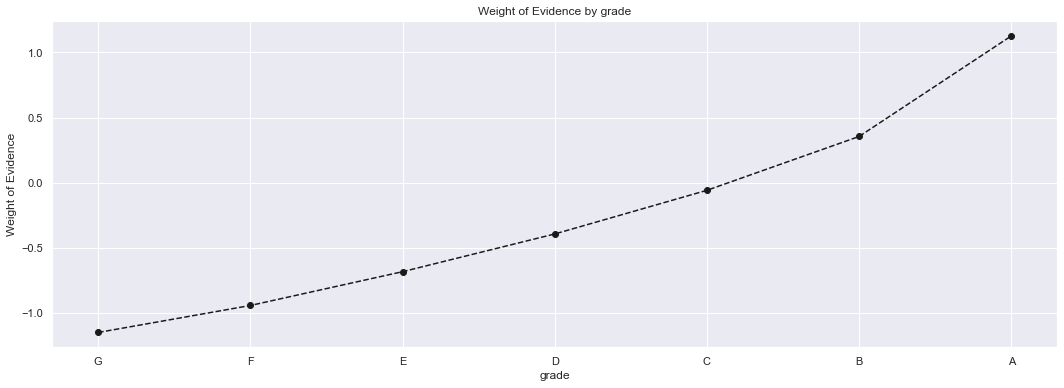

In [55]:
plot_by_woe(df_temp)

In [56]:
df_temp = woe(df_input_train,'home_ownership',df_target_train)
df_temp

,home_ownership,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,OTHER,134,0.783582,0.000383,105.0,29.0,0.000337,0.000761,-0.815119,0.022239
1,NONE,37,0.864865,0.000106,32.0,5.0,0.000103,0.000131,-0.245485,0.022239
2,RENT,141082,0.874009,0.403422,123307.0,17775.0,0.395695,0.466633,-0.164899,0.022239
3,OWN,31326,0.892900,0.089576,27971.0,3355.0,0.089760,0.088076,0.018933,0.022239
4,MORTGAGE,177134,0.904434,0.506512,160206.0,16928.0,0.514105,0.444398,0.145708,0.022239


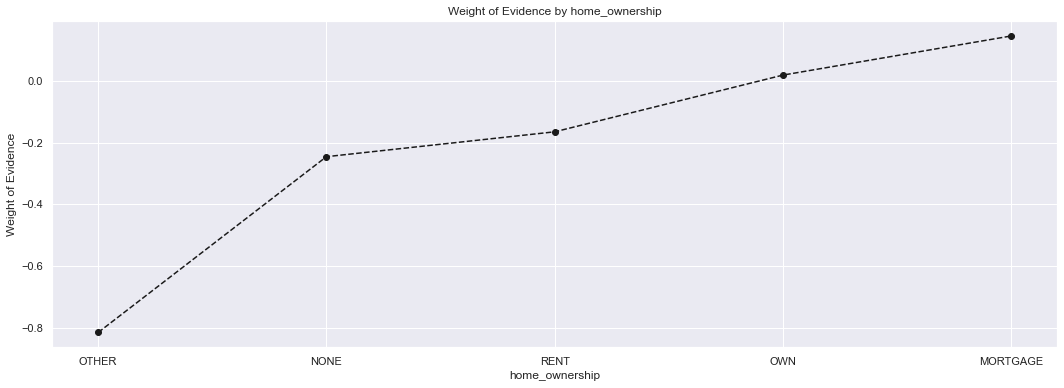

In [57]:
plot_by_woe(df_temp)

In [58]:
df_input_prep['home_ownership:RENT_OTHER_NONE_ANY']=sum([df_input_prep['home_ownership:RENT'],
                                                          df_input_prep['home_ownership:OTHER'],
                                                          df_input_prep['home_ownership:NONE'],
                                                          df_input_prep['home_ownership:ANY']]
                                                         )

In [59]:
df_input_prep['addr_state'].unique()

array(['WA', 'VA', 'NY', 'AZ', 'WY', 'OR', 'AL', 'CA', 'IL', 'MI', 'FL',
       'OH', 'NJ', 'TX', 'WI', 'NV', 'CO', 'DC', 'PA', 'NM', 'IN', 'OK',
       'GA', 'CT', 'SC', 'WV', 'MD', 'TN', 'MO', 'KY', 'MA', 'UT', 'NH',
       'MN', 'HI', 'KS', 'NC', 'RI', 'LA', 'SD', 'VT', 'AR', 'MS', 'MT',
       'AK', 'DE', 'NE', 'ID', 'IA', 'ME'], dtype=object)

In [60]:
df_temp = woe(df_input_prep,'addr_state',df_target_prep)

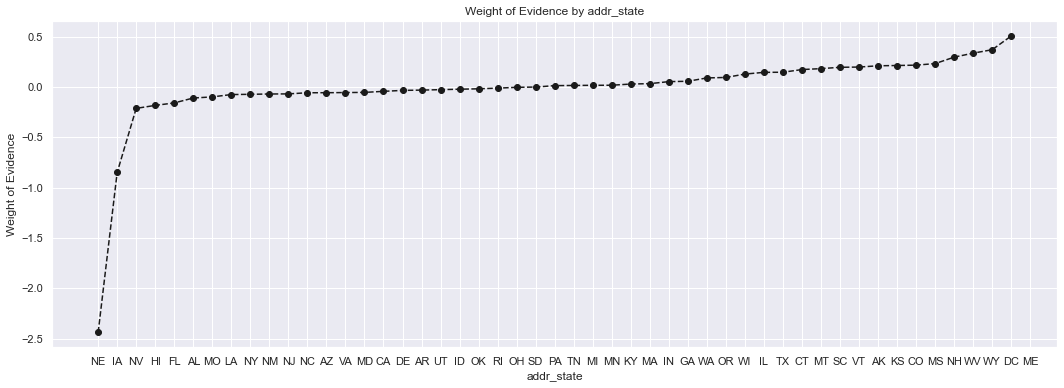

In [61]:
plot_by_woe(df_temp)

In [62]:
if ['addr_state:ND'] in df_input_prep.columns.values:
    pass
else:
    df_input_prep['addr_state:ND'] = 0

In [63]:
#first lets seperate state with high value into its own categories
df_temp.sort_values(by ='count', ascending=False)

#CA, NY, TX and FL is high in count so it should be seperate into its own categories

,addr_state,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
15,CA,53771,0.886779,0.153758,47683.0,6088.0,0.153016,0.159824,-0.043528,inf
8,NY,30067,0.883793,0.085976,26573.0,3494.0,0.085273,0.091725,-0.072935,inf
36,TX,27313,0.904478,0.078101,24704.0,2609.0,0.079276,0.068492,0.146215,inf
4,FL,23713,0.874710,0.067807,20742.0,2971.0,0.066562,0.077995,-0.158521,inf
35,IL,13993,0.904381,0.040013,12655.0,1338.0,0.040610,0.035125,0.145093,inf
...,...,...,...,...,...,...,...,...,...,...
40,VT,702,0.908832,0.002007,638.0,64.0,0.002047,0.001680,0.197672,inf
0,NE,12,0.416667,0.000034,5.0,7.0,0.000016,0.000184,-2.438256,inf
1,IA,9,0.777778,0.000026,7.0,2.0,0.000022,0.000053,-0.849020,inf
19,ID,9,0.888889,0.000026,8.0,1.0,0.000026,0.000026,-0.022342,inf


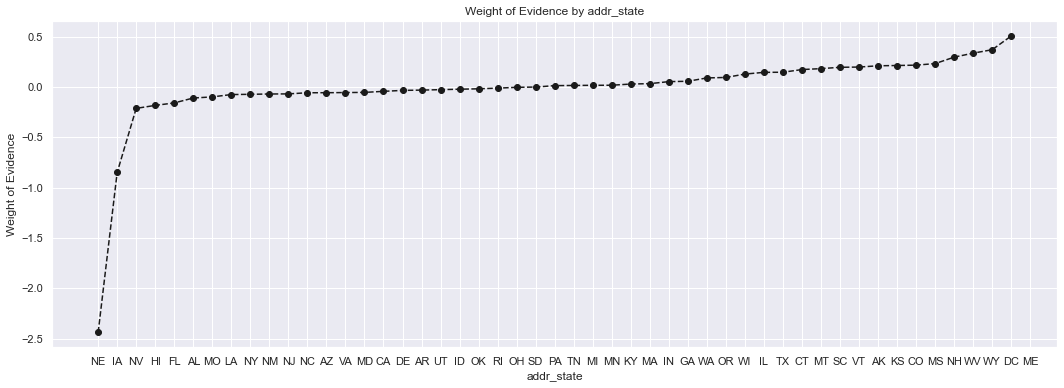

In [64]:
plot_by_woe(df_temp.iloc[:, :])

In [65]:
df_input_prep['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_input_prep['addr_state:ND'], df_input_prep['addr_state:NE'],
                                                         df_input_prep['addr_state:IA'], df_input_prep['addr_state:NV'],
                                                         df_input_prep['addr_state:FL'], df_input_prep['addr_state:HI'],
                                                         df_input_prep['addr_state:AL']])

df_input_prep['addr_state:NM_VA'] = sum([df_input_prep['addr_state:NM'], df_input_prep['addr_state:VA']])

df_input_prep['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_input_prep['addr_state:OK'], df_input_prep['addr_state:TN'],
                                              df_input_prep['addr_state:MO'], df_input_prep['addr_state:LA'],
                                              df_input_prep['addr_state:MD'], df_input_prep['addr_state:NC']])

df_input_prep['addr_state:UT_KY_AZ_NJ'] = sum([df_input_prep['addr_state:UT'], df_input_prep['addr_state:KY'],
                                              df_input_prep['addr_state:AZ'], df_input_prep['addr_state:NJ']])

df_input_prep['addr_state:AR_MI_PA_OH_MN'] = sum([df_input_prep['addr_state:AR'], df_input_prep['addr_state:MI'],
                                              df_input_prep['addr_state:PA'], df_input_prep['addr_state:OH'],
                                              df_input_prep['addr_state:MN']])

df_input_prep['addr_state:RI_MA_DE_SD_IN'] = sum([df_input_prep['addr_state:RI'], df_input_prep['addr_state:MA'],
                                              df_input_prep['addr_state:DE'], df_input_prep['addr_state:SD'],
                                              df_input_prep['addr_state:IN']])

df_input_prep['addr_state:GA_WA_OR'] = sum([df_input_prep['addr_state:GA'], df_input_prep['addr_state:WA'],
                                              df_input_prep['addr_state:OR']])

df_input_prep['addr_state:WI_MT'] = sum([df_input_prep['addr_state:WI'], df_input_prep['addr_state:MT']])

df_input_prep['addr_state:IL_CT'] = sum([df_input_prep['addr_state:IL'], df_input_prep['addr_state:CT']])

df_input_prep['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_input_prep['addr_state:KS'], df_input_prep['addr_state:SC'],
                                              df_input_prep['addr_state:CO'], df_input_prep['addr_state:VT'],
                                              df_input_prep['addr_state:AK'], df_input_prep['addr_state:MS']])

df_input_prep['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_input_prep['addr_state:WV'], df_input_prep['addr_state:NH'],
                                              df_input_prep['addr_state:WY'], df_input_prep['addr_state:DC'],
                                              df_input_prep['addr_state:ME'], df_input_prep['addr_state:ID']])

In [66]:
df_temp = woe(df_input_prep, 'verification_status', df_target_prep)
df_temp

,verification_status,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,Verified,126143,0.872851,0.360704,110104.0,16039.0,0.353327,0.421060,-0.175381,0.021086
1,Source Verified,112274,0.896681,0.321046,100674.0,11600.0,0.323066,0.304526,0.059099,0.021086
2,Not Verified,111296,0.906079,0.318250,100843.0,10453.0,0.323608,0.274415,0.164892,0.021086


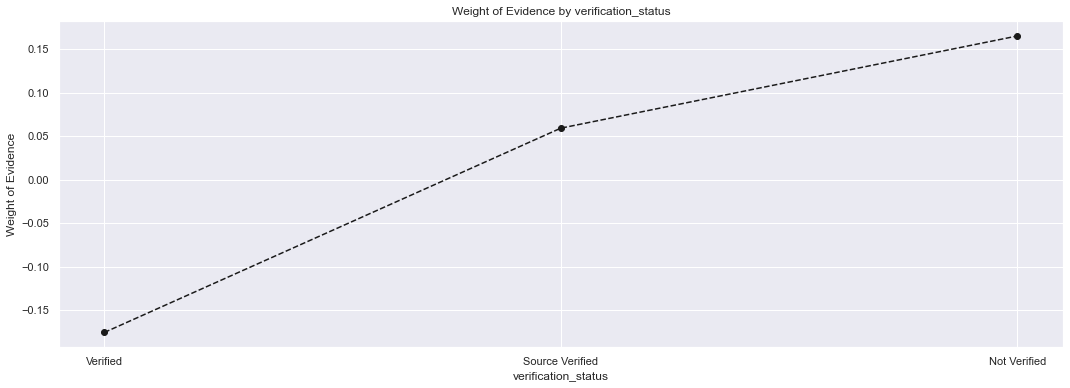

In [67]:
plot_by_woe(df_temp)

In [68]:
df_temp = woe(df_input_prep, 'purpose', df_target_prep)
df_temp

,purpose,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,small_business,5299,0.787885,0.015152,4175.0,1124.0,0.013398,0.029508,-0.789563,0.036154
1,educational,308,0.805195,0.000881,248.0,60.0,0.000796,0.001575,-0.682699,0.036154
2,renewable_energy,268,0.835821,0.000766,224.0,44.0,0.000719,0.001155,-0.474327,0.036154
3,moving,2245,0.844543,0.006420,1896.0,349.0,0.006084,0.009162,-0.409354,0.036154
4,house,1667,0.857828,0.004767,1430.0,237.0,0.004589,0.006222,-0.304414,0.036154
5,other,17683,0.861505,0.050564,15234.0,2449.0,0.048886,0.064292,-0.273933,0.036154
6,medical,3456,0.867188,0.009882,2997.0,459.0,0.009617,0.012050,-0.225467,0.036154
7,wedding,1756,0.871868,0.005021,1531.0,225.0,0.004913,0.005907,-0.184207,0.036154
8,debt_consolidation,205529,0.887339,0.587708,182374.0,23155.0,0.585243,0.607870,-0.037935,0.036154
9,vacation,1879,0.887706,0.005373,1668.0,211.0,0.005353,0.005539,-0.034261,0.036154


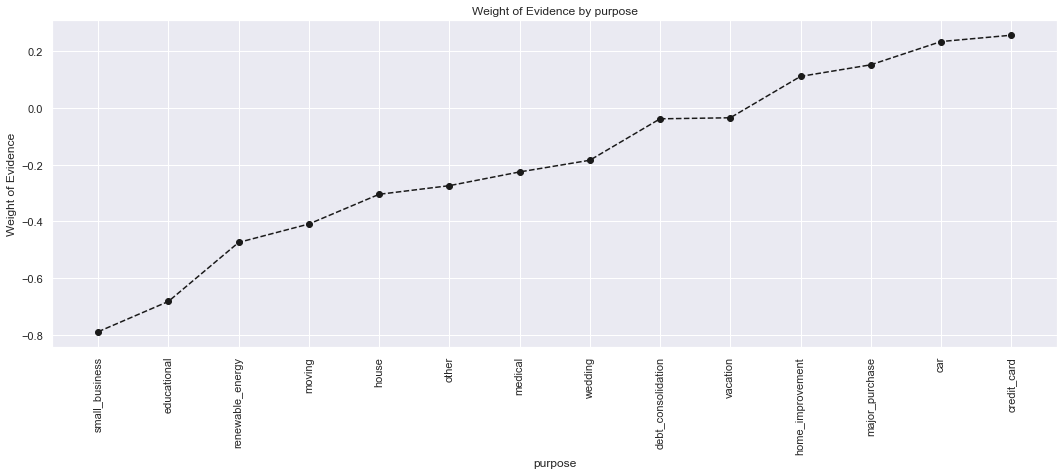

In [69]:
plot_by_woe(df_temp, 90)

In [70]:
df_input_prep['purpose:sm_b_educ'] = sum([ df_input_prep['purpose:small_business'],df_input_prep['purpose:educational']])
df_input_prep['purpose:ren_en_mov_house_other'] = sum([df_input_prep['purpose:renewable_energy'],df_input_prep['purpose:moving'], df_input_prep['purpose:house'],df_input_prep['purpose:other']])
df_input_prep['purpose:med_wed_vac'] = sum([df_input_prep['purpose:medical'],df_input_prep['purpose:wedding'],df_input_prep['purpose:vacation']])
df_input_prep['purpose:major_purch__car__home_impr'] = sum([df_input_prep['purpose:major_purchase'], df_input_prep['purpose:car'],df_input_prep['purpose:home_improvement']])

### Weight of Evidence for Continuous Variable

In [71]:
def woe_cont(df, discrete, dependent_var_df):
    df = pd.concat([df[discrete], dependent_var_df],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                   df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0], 'count', 'proportion_of_good']
    df['proportion_of_count'] = df['count']/df['count'].sum()
    df['n_good'] = df['proportion_of_good']*df['count']
    df['n_bad'] = (1-df['proportion_of_good'])*df['count']
    df['prop_n_good'] = df['n_good']/df['n_good'].sum() 
    df['prop_n_bad'] = df['n_bad']/df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good']/df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop=True)
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad'])*df['WoE']
    df['IV'] = df.IV.sum() 
    return df

In [72]:
df_temp = woe_cont(df_input_prep, 'emp_length_int', df_target_prep)
df_temp

,emp_length_int,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0,42737,0.875705,0.122206,37425.0,5312.0,0.120098,0.139452,-0.149413,0.007224
1,1,22124,0.888176,0.063263,19650.0,2474.0,0.063057,0.064948,-0.029542,0.007224
2,2,30970,0.890507,0.088558,27579.0,3391.0,0.088502,0.089021,-0.005854,0.007224
3,3,27572,0.891230,0.078842,24573.0,2999.0,0.078855,0.078730,0.001586,0.007224
4,4,21041,0.890452,0.060166,18736.0,2305.0,0.060124,0.060511,-0.006417,0.007224
5,5,22988,0.883635,0.065734,20313.0,2675.0,0.065185,0.070225,-0.074472,0.007224
6,6,19499,0.885122,0.055757,17259.0,2240.0,0.055385,0.058805,-0.059926,0.007224
7,7,19701,0.887721,0.056335,17489.0,2212.0,0.056123,0.058070,-0.034108,0.007224
8,8,16822,0.889490,0.048102,14963.0,1859.0,0.048017,0.048803,-0.016242,0.007224
9,9,13464,0.890597,0.038500,11991.0,1473.0,0.038479,0.038670,-0.004928,0.007224


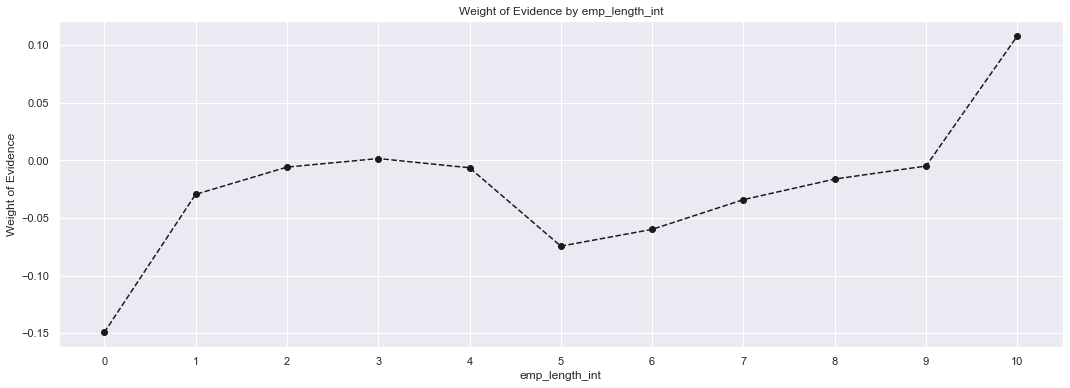

In [73]:
plot_by_woe(df_temp)

In [74]:
df_input_prep['emp_length_int:0'] = np.where(df_input_prep['emp_length_int'].isin([0]),1,0)
df_input_prep['emp_length_int:1-3'] = np.where(df_input_prep['emp_length_int'].isin(range(1,4)),1,0)
df_input_prep['emp_length_int:4'] = np.where(df_input_prep['emp_length_int'].isin([4]),1,0)
df_input_prep['emp_length_int:5-6'] = np.where(df_input_prep['emp_length_int'].isin(range(5,7)),1,0)
df_input_prep['emp_length_int:7-9'] = np.where(df_input_prep['emp_length_int'].isin(range(7,10)),1,0)
df_input_prep['emp_length_int:10'] = np.where(df_input_prep['emp_length_int'].isin([10]),1,0)        

In [75]:
df_input_prep['earliest_cr_line_in_mnths_factor'] = pd.cut(df_input_prep['earliest_cr_line_in_mnths'], 50)
df_temp = woe_cont(df_input_prep, 'earliest_cr_line_in_mnths_factor', df_target_prep)
df_temp

,earliest_cr_line_in_mnths_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.588, 11.76]",18,0.833333,0.000051,15.0,3.0,0.000048,0.000079,-0.492346,0.017184
1,"(11.76, 23.52]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.017184
2,"(23.52, 35.28]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.017184
3,"(35.28, 47.04]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.017184
4,"(47.04, 58.8]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,0.017184
...,...,...,...,...,...,...,...,...,...,...
45,"(529.2, 540.96]",500,0.910000,0.001430,455.0,45.0,0.001460,0.001181,0.211852,0.017184
46,"(540.96, 552.72]",478,0.916318,0.001367,438.0,40.0,0.001406,0.001050,0.291556,0.017184
47,"(552.72, 564.48]",300,0.920000,0.000858,276.0,24.0,0.000886,0.000630,0.340564,0.017184
48,"(564.48, 576.24]",316,0.889241,0.000904,281.0,35.0,0.000902,0.000919,-0.018777,0.017184


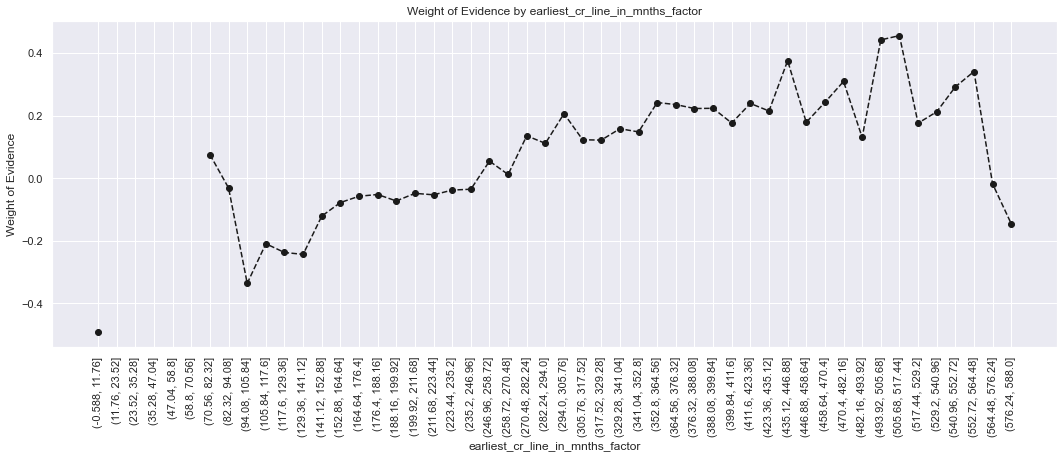

In [76]:
plot_by_woe(df_temp, 90)

In [77]:
df_input_prep['earliest_cr_line_in_mnths:<140'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:141-164'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140, 165)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:165-247'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(165, 248)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:248-270'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(248, 271)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:271-352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(271, 353)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:>352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(353, int(df_input_prep['earliest_cr_line_in_mnths'].max()))), 1, 0)

In [78]:
df_temp = woe_cont(df_input_prep, 'delinq_2yrs', df_target_prep)
df_temp

,delinq_2yrs,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0.0,287176,0.890896,0.821176,255844.0,31332.0,0.821010,0.822535,-0.001855,inf
1,1.0,42225,0.893902,0.120742,37745.0,4480.0,0.121125,0.117610,0.029447,inf
2,2.0,12250,0.888408,0.035029,10883.0,1367.0,0.034924,0.035887,-0.027200,inf
3,3.0,4254,0.880348,0.012164,3745.0,509.0,0.012018,0.013362,-0.106055,inf
4,4.0,1780,0.894944,0.005090,1593.0,187.0,0.005112,0.004909,0.040482,inf
...,...,...,...,...,...,...,...,...,...,...
17,17.0,2,0.500000,0.000006,1.0,1.0,0.000003,0.000026,-2.101783,inf
18,18.0,5,1.000000,0.000014,5.0,0.0,0.000016,0.000000,inf,inf
19,21.0,2,0.500000,0.000006,1.0,1.0,0.000003,0.000026,-2.101783,inf
20,24.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf


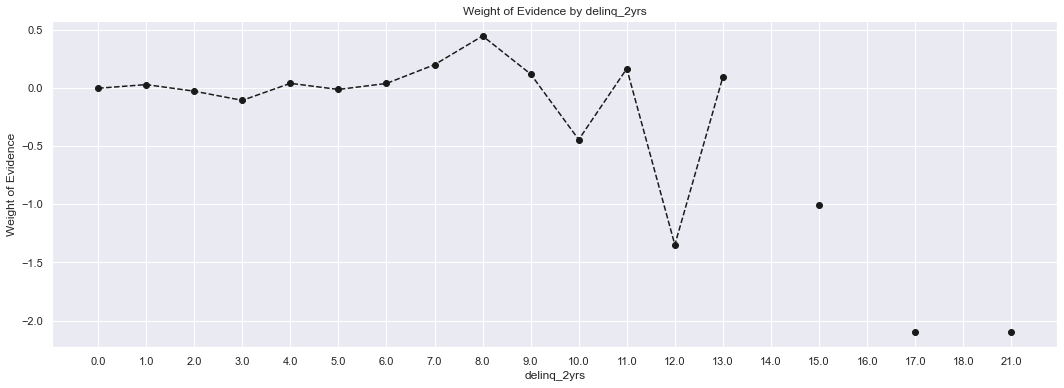

In [79]:
plot_by_woe(df_temp)

In [80]:
df_input_prep['delinq_2yrs:0'] = np.where((df_input_prep['delinq_2yrs'] == 0), 1, 0)
df_input_prep['delinq_2yrs:1-6'] = np.where((df_input_prep['delinq_2yrs'] >= 1) & (df_input_prep['delinq_2yrs'] <= 6), 1, 0)
df_input_prep['delinq_2yrs:>6'] = np.where((df_input_prep['delinq_2yrs'] >6), 1, 0)

In [81]:
df_temp = woe_cont(df_input_prep, 'inq_last_6mths', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,inq_last_6mths,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0.0,181377,0.908726,0.518645,164822.0,16555.0,0.528918,0.434606,0.196395,inf
1,1.0,97560,0.884686,0.278972,86310.0,11250.0,0.276971,0.295338,-0.064206,inf
2,2.0,43260,0.865141,0.123701,37426.0,5834.0,0.120101,0.153156,-0.243121,inf
3,3.0,18800,0.843032,0.053758,15849.0,2951.0,0.050860,0.077470,-0.420821,inf
4,4.0,5407,0.846125,0.015461,4575.0,832.0,0.014681,0.021842,-0.397254,inf
...,...,...,...,...,...,...,...,...,...,...
19,19.0,2,1.000000,0.000006,2.0,0.0,0.000006,0.000000,inf,inf
20,20.0,1,0.000000,0.000003,0.0,1.0,0.000000,0.000026,-inf,inf
21,27.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
22,28.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf


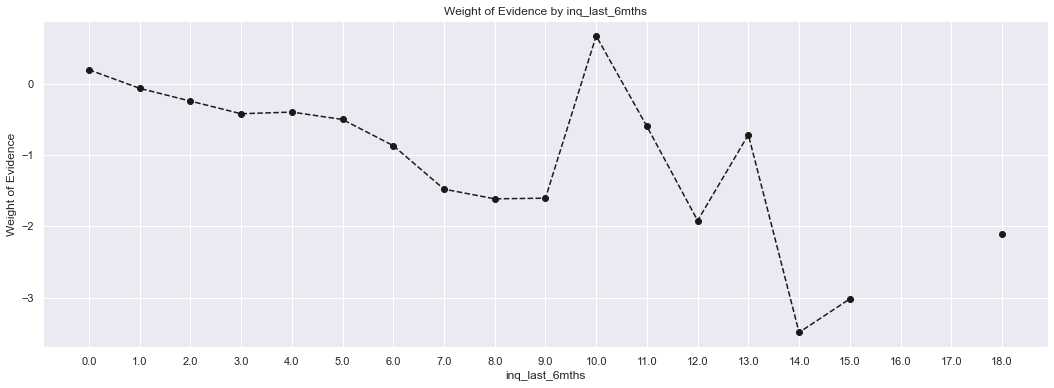

In [82]:
plot_by_woe(df_temp)

In [83]:
df_input_prep['inq_last_6mths:0'] = np.where((df_input_prep['inq_last_6mths'] == 0), 1, 0)
df_input_prep['inq_last_6mths:1-2'] = np.where((df_input_prep['inq_last_6mths'] >= 1) & (df_input_prep['inq_last_6mths'] <= 2), 1, 0)
df_input_prep['inq_last_6mths:3-6'] = np.where((df_input_prep['inq_last_6mths'] >= 3) & (df_input_prep['inq_last_6mths'] <= 6), 1, 0)
df_input_prep['inq_last_6mths:>6'] = np.where((df_input_prep['inq_last_6mths'] > 6), 1, 0)

In [84]:
df_temp = woe_cont(df_input_prep, 'open_acc', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,open_acc,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0.0,23,0.782609,0.000066,18.0,5.0,0.000058,0.000131,-0.820850,inf
1,1.0,110,0.854545,0.000315,94.0,16.0,0.000302,0.000420,-0.331077,inf
2,2.0,1358,0.838733,0.003883,1139.0,219.0,0.003655,0.005749,-0.452949,inf
3,3.0,4077,0.863625,0.011658,3521.0,556.0,0.011299,0.014596,-0.256051,inf
4,4.0,9365,0.889375,0.026779,8329.0,1036.0,0.026728,0.027197,-0.017407,inf
...,...,...,...,...,...,...,...,...,...,...
56,58.0,2,1.000000,0.000006,2.0,0.0,0.000006,0.000000,inf,inf
57,61.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
58,75.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
59,76.0,1,0.000000,0.000003,0.0,1.0,0.000000,0.000026,-inf,inf


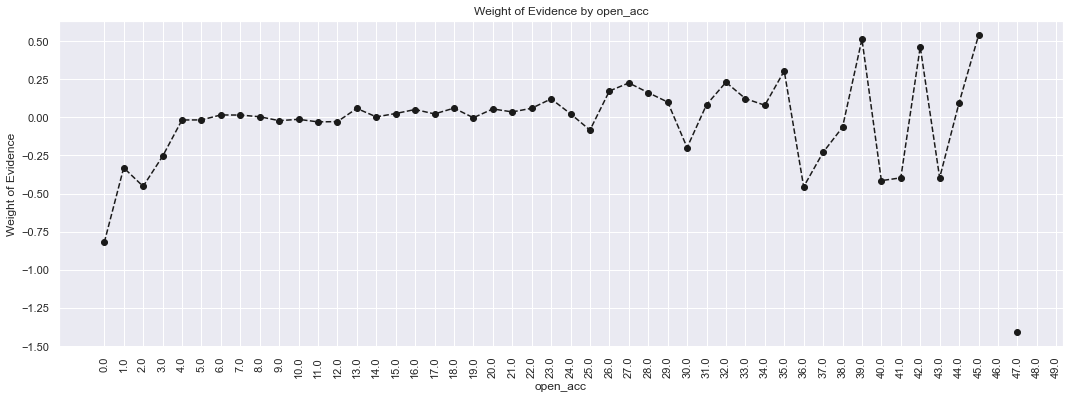

In [85]:
plot_by_woe(df_temp, 90)

In [86]:
df_input_prep['open_acc:0'] = np.where((df_input_prep['open_acc'] == 0), 1, 0)
df_input_prep['open_acc:1-3'] = np.where((df_input_prep['open_acc'] >= 1) & (df_input_prep['open_acc'] <= 3), 1, 0)
df_input_prep['open_acc:4-12'] = np.where((df_input_prep['open_acc'] >= 4) & (df_input_prep['open_acc'] <= 12), 1, 0)
df_input_prep['open_acc:13-17'] = np.where((df_input_prep['open_acc'] >= 13) & (df_input_prep['open_acc'] <= 17), 1, 0)
df_input_prep['open_acc:18-22'] = np.where((df_input_prep['open_acc'] >= 18) & (df_input_prep['open_acc'] <= 22), 1, 0)
df_input_prep['open_acc:23-25'] = np.where((df_input_prep['open_acc'] >= 23) & (df_input_prep['open_acc'] <= 25), 1, 0)
df_input_prep['open_acc:26-30'] = np.where((df_input_prep['open_acc'] >= 26) & (df_input_prep['open_acc'] <= 30), 1, 0)
df_input_prep['open_acc:>=31'] = np.where((df_input_prep['open_acc'] >= 31), 1, 0)

In [87]:
df_temp = woe_cont(df_input_prep, 'pub_rec', df_target_prep)
df_temp

,pub_rec,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0.0,303789,0.890108,0.868681,270405.0,33384.0,0.867737,0.876404,-0.009939,inf
1,1.0,39672,0.895796,0.113442,35538.0,4134.0,0.114042,0.108527,0.049574,inf
2,2.0,4249,0.904919,0.012150,3845.0,404.0,0.012339,0.010606,0.151331,inf
3,3.0,1219,0.914684,0.003486,1115.0,104.0,0.003578,0.002730,0.270435,inf
4,4.0,364,0.903846,0.001041,329.0,35.0,0.001056,0.000919,0.138926,inf
...,...,...,...,...,...,...,...,...,...,...
19,21.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
20,34.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
21,40.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
22,54.0,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf


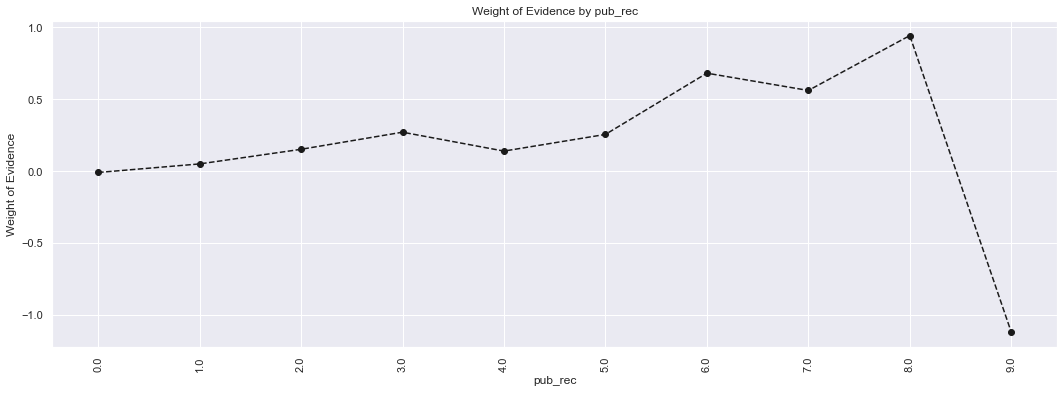

In [88]:
plot_by_woe(df_temp, 90)

In [89]:
df_input_prep['pub_rec:0-2'] = np.where((df_input_prep['pub_rec'] >= 0) & (df_input_prep['pub_rec'] <= 2), 1, 0)
df_input_prep['pub_rec:3-4'] = np.where((df_input_prep['pub_rec'] >= 3) & (df_input_prep['pub_rec'] <= 4), 1, 0)
df_input_prep['pub_rec:>=5'] = np.where((df_input_prep['pub_rec'] >= 5), 1, 0)

In [90]:
df_temp = woe_cont(df_input_prep, 'acc_now_delinq', df_target_prep)
df_temp

,acc_now_delinq,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,0.0,348406,0.891052,0.996263,310448.0,37958.0,0.996236,0.996482,-0.000247,inf
1,1.0,1220,0.897541,0.003489,1095.0,125.0,0.003514,0.003282,0.068412,inf
2,2.0,72,0.916667,0.000206,66.0,6.0,0.000212,0.000158,0.296112,inf
3,3.0,10,0.800000,0.000029,8.0,2.0,0.000026,0.000053,-0.715489,inf
4,4.0,3,1.000000,0.000009,3.0,0.0,0.000010,0.000000,inf,inf
5,5.0,2,0.500000,0.000006,1.0,1.0,0.000003,0.000026,-2.101783,inf


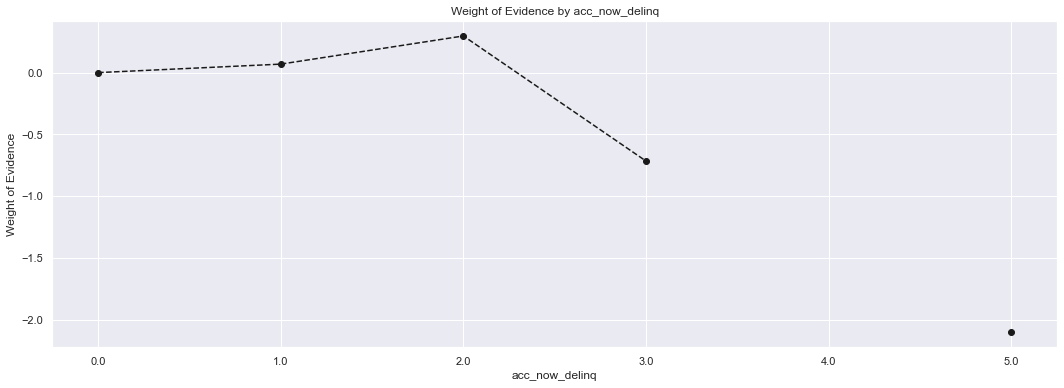

In [91]:
plot_by_woe(df_temp)

In [92]:
df_input_prep['acc_now_delinq:0'] = np.where((df_input_prep['acc_now_delinq'] == 0), 1, 0)
df_input_prep['acc_now_delinq:>=1'] = np.where((df_input_prep['acc_now_delinq'] >= 1), 1, 0)

In [93]:
df_input_prep['total_rev_hi_lim_factor'] = pd.cut(df_input_prep['total_rev_hi_lim'], 2000)
df_temp = woe_cont(df_input_prep, 'total_rev_hi_lim_factor', df_target_prep)
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,total_rev_hi_lim_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-9999.999, 5000.0]",18247,0.864526,0.052177,15775.0,2472.0,0.050622,0.064896,-0.248385,inf
1,"(5000.0, 9999.999]",49333,0.875459,0.141067,43189.0,6144.0,0.138595,0.161294,-0.151674,inf
2,"(9999.999, 14999.998]",55657,0.880752,0.159151,49020.0,6637.0,0.157306,0.174236,-0.102215,inf
3,"(14999.998, 19999.998]",48053,0.878780,0.137407,42228.0,5825.0,0.135511,0.152919,-0.120859,inf
4,"(19999.998, 24999.997]",39119,0.887446,0.111860,34716.0,4403.0,0.111405,0.115589,-0.036869,inf
...,...,...,...,...,...,...,...,...,...,...
1995,"(9974999.002, 9979999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
1996,"(9979999.002, 9984999.002]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
1997,"(9984999.002, 9989999.001]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
1998,"(9989999.001, 9994999.0]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


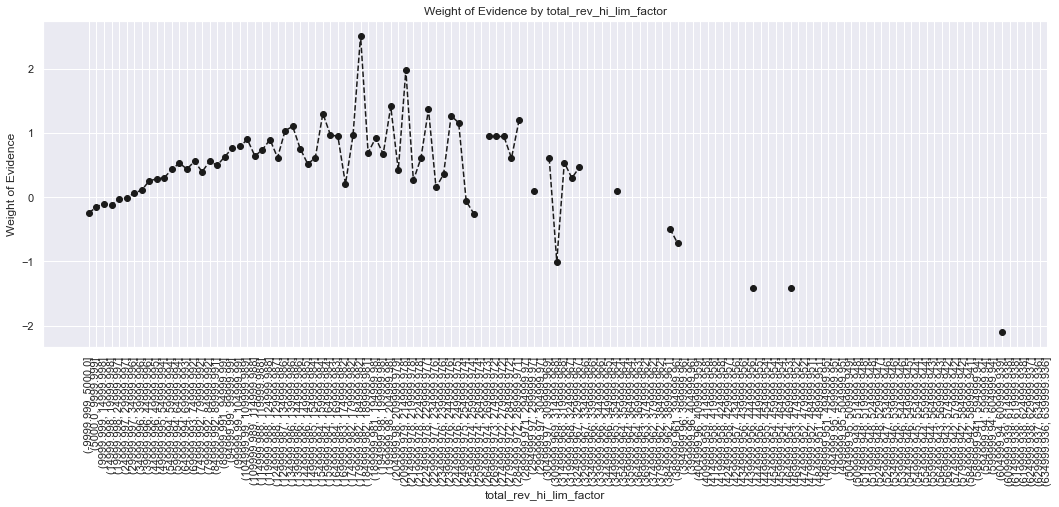

In [94]:
plot_by_woe(df_temp, 90)

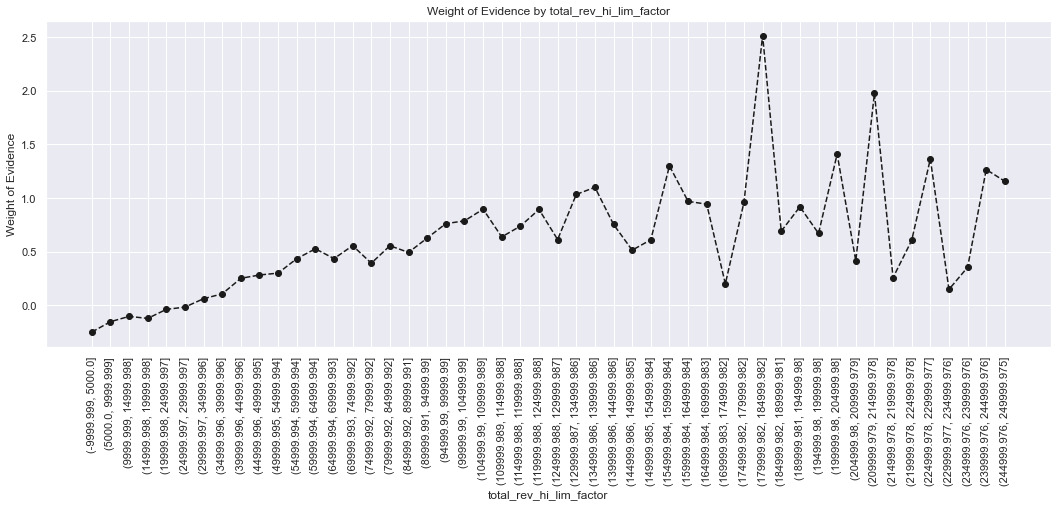

In [95]:
plot_by_woe(df_temp.iloc[:50,:], 90)

In [96]:
df_input_prep['total_rev_hi_lim:<=5K'] = np.where((df_input_prep['total_rev_hi_lim'] <= 5000), 1, 0)
df_input_prep['total_rev_hi_lim:5K-10K'] = np.where((df_input_prep['total_rev_hi_lim'] > 5000) & (df_input_prep['total_rev_hi_lim'] <= 10000), 1, 0)
df_input_prep['total_rev_hi_lim:10K-20K'] = np.where((df_input_prep['total_rev_hi_lim'] > 10000) & (df_input_prep['total_rev_hi_lim'] <= 20000), 1, 0)
df_input_prep['total_rev_hi_lim:20K-30K'] = np.where((df_input_prep['total_rev_hi_lim'] > 20000) & (df_input_prep['total_rev_hi_lim'] <= 30000), 1, 0)
df_input_prep['total_rev_hi_lim:30K-40K'] = np.where((df_input_prep['total_rev_hi_lim'] > 30000) & (df_input_prep['total_rev_hi_lim'] <= 40000), 1, 0)
df_input_prep['total_rev_hi_lim:40K-55K'] = np.where((df_input_prep['total_rev_hi_lim'] > 40000) & (df_input_prep['total_rev_hi_lim'] <= 55000), 1, 0)
df_input_prep['total_rev_hi_lim:55K-95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 55000) & (df_input_prep['total_rev_hi_lim'] <= 95000), 1, 0)
df_input_prep['total_rev_hi_lim:>95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 95000), 1, 0)

In [97]:
df_input_prep['annual_inc_factor'] = pd.cut(df_input_prep['annual_inc'], 100)
df_temp = woe_cont(df_input_prep, 'annual_inc_factor', df_target_prep)
df_temp

,annual_inc_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-5602.104, 76877.04]",229505,0.877798,0.656267,201459.0,28046.0,0.646487,0.736270,-0.130044,inf
1,"(76877.04, 151858.08]",104848,0.914915,0.299812,95927.0,8921.0,0.307832,0.234196,0.273396,inf
2,"(151858.08, 226839.12]",11200,0.925893,0.032026,10370.0,830.0,0.033278,0.021789,0.423463,inf
3,"(226839.12, 301820.16]",2658,0.925884,0.007601,2461.0,197.0,0.007897,0.005172,0.423336,inf
4,"(301820.16, 376801.2]",641,0.936037,0.001833,600.0,41.0,0.001925,0.001076,0.581574,inf
...,...,...,...,...,...,...,...,...,...,...
95,"(7125094.8, 7200075.84]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
96,"(7200075.84, 7275056.88]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
97,"(7275056.88, 7350037.92]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
98,"(7350037.92, 7425018.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


In [98]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['annual_inc'] <= 150000, : ]

In [99]:
df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)
df_temp = woe_cont(df_input_prep_temp, 'annual_inc_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-99-83cf6fca08f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)


,annual_inc_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(1747.896, 4858.08]",18,0.722222,0.000054,13.0,5.0,0.000044,0.000135,-1.129405,0.05287
1,"(4858.08, 7820.16]",38,0.842105,0.000114,32.0,6.0,0.000108,0.000162,-0.410940,0.05287
2,"(7820.16, 10782.24]",320,0.840625,0.000957,269.0,51.0,0.000905,0.001380,-0.422030,0.05287
3,"(10782.24, 13744.32]",667,0.823088,0.001996,549.0,118.0,0.001847,0.003193,-0.547502,0.05287
4,"(13744.32, 16706.4]",1277,0.837118,0.003821,1069.0,208.0,0.003596,0.005628,-0.447975,0.05287
...,...,...,...,...,...,...,...,...,...,...
45,"(135189.6, 138151.68]",687,0.927220,0.002055,637.0,50.0,0.002143,0.001353,0.459830,0.05287
46,"(138151.68, 141113.76]",2277,0.920070,0.006813,2095.0,182.0,0.007047,0.004925,0.358386,0.05287
47,"(141113.76, 144075.84]",646,0.921053,0.001933,595.0,51.0,0.002002,0.001380,0.371820,0.05287
48,"(144075.84, 147037.92]",1176,0.924320,0.003519,1087.0,89.0,0.003657,0.002408,0.417624,0.05287


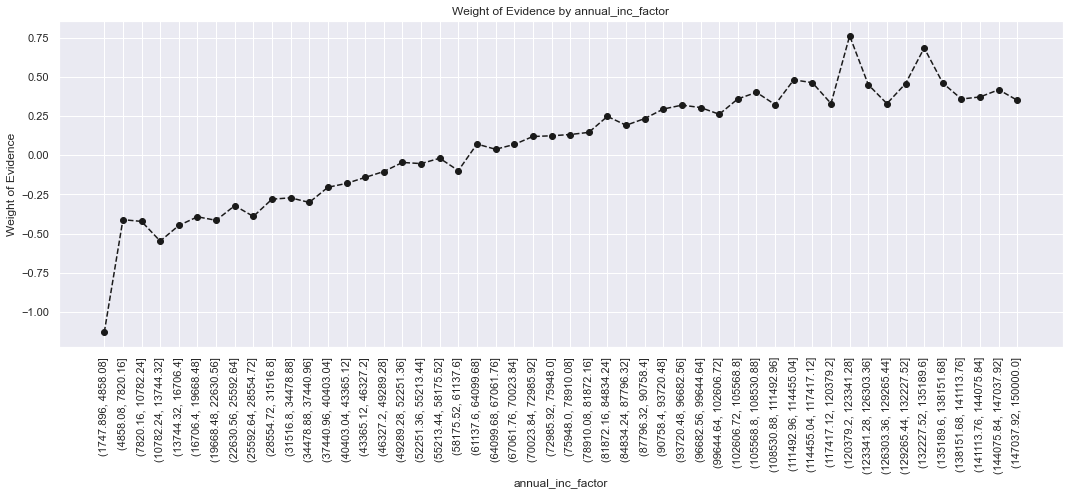

In [100]:
plot_by_woe(df_temp,90)

In [101]:
df_input_prep['annual_inc:<20K'] = np.where((df_input_prep['annual_inc'] <= 20000), 1, 0)
df_input_prep['annual_inc:20K-30K'] = np.where((df_input_prep['annual_inc'] > 20000) & (df_input_prep['annual_inc'] <= 30000), 1, 0)
df_input_prep['annual_inc:30K-40K'] = np.where((df_input_prep['annual_inc'] > 30000) & (df_input_prep['annual_inc'] <= 40000), 1, 0)
df_input_prep['annual_inc:40K-50K'] = np.where((df_input_prep['annual_inc'] > 40000) & (df_input_prep['annual_inc'] <= 50000), 1, 0)
df_input_prep['annual_inc:50K-60K'] = np.where((df_input_prep['annual_inc'] > 50000) & (df_input_prep['annual_inc'] <= 60000), 1, 0)
df_input_prep['annual_inc:60K-70K'] = np.where((df_input_prep['annual_inc'] > 60000) & (df_input_prep['annual_inc'] <= 70000), 1, 0)
df_input_prep['annual_inc:70K-80K'] = np.where((df_input_prep['annual_inc'] > 70000) & (df_input_prep['annual_inc'] <= 80000), 1, 0)
df_input_prep['annual_inc:80K-90K'] = np.where((df_input_prep['annual_inc'] > 80000) & (df_input_prep['annual_inc'] <= 90000), 1, 0)
df_input_prep['annual_inc:90K-100K'] = np.where((df_input_prep['annual_inc'] > 90000) & (df_input_prep['annual_inc'] <= 100000), 1, 0)
df_input_prep['annual_inc:100K-125K'] = np.where((df_input_prep['annual_inc'] > 100000) & (df_input_prep['annual_inc'] <= 125000), 1, 0)
df_input_prep['annual_inc:125K-150K'] = np.where((df_input_prep['annual_inc'] > 125000) & (df_input_prep['annual_inc'] <= 150000), 1, 0)
df_input_prep['annual_inc:>150K'] = np.where((df_input_prep['annual_inc'] > 150000), 1, 0)

In [102]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_delinq'])]
df_input_prep_temp['mths_since_last_delinq_factor'] = pd.cut(df_input_prep_temp['mths_since_last_delinq'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_delinq_factor', df_target_prep[df_input_prep_temp.index])
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_delinq_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.188, 3.76]",192405,0.889275,0.550180,171101.0,21304.0,0.549068,0.559278,-0.018424,inf
1,"(3.76, 7.52]",10423,0.886405,0.029804,9239.0,1184.0,0.029648,0.031083,-0.047248,inf
2,"(7.52, 11.28]",12510,0.893365,0.035772,11176.0,1334.0,0.035864,0.035020,0.023803,inf
3,"(11.28, 15.04]",12357,0.889941,0.035335,10997.0,1360.0,0.035290,0.035703,-0.011646,inf
4,"(15.04, 18.8]",8755,0.894003,0.025035,7827.0,928.0,0.025117,0.024362,0.030519,inf
...,...,...,...,...,...,...,...,...,...,...
45,"(169.2, 172.96]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
46,"(172.96, 176.72]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
47,"(176.72, 180.48]",1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,inf
48,"(180.48, 184.24]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


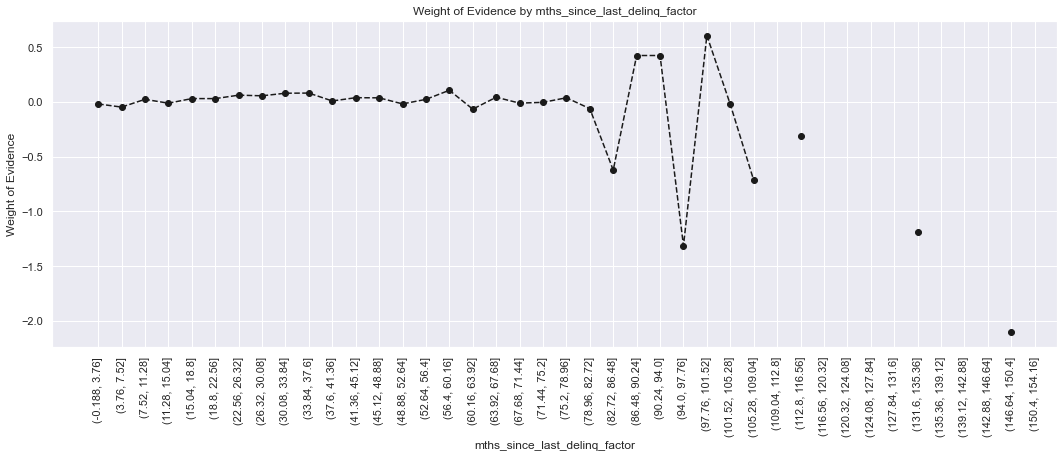

In [103]:
plot_by_woe(df_temp, 90)

In [104]:
df_input_prep['mths_since_last_delinq:Missing'] = np.where((df_input_prep['mths_since_last_delinq'].isnull()), 1, 0)
df_input_prep['mths_since_last_delinq:0-3'] = np.where((df_input_prep['mths_since_last_delinq'] >= 0) & (df_input_prep['mths_since_last_delinq'] <= 3), 1, 0)
df_input_prep['mths_since_last_delinq:4-30'] = np.where((df_input_prep['mths_since_last_delinq'] >= 4) & (df_input_prep['mths_since_last_delinq'] <= 30), 1, 0)
df_input_prep['mths_since_last_delinq:31-56'] = np.where((df_input_prep['mths_since_last_delinq'] >= 31) & (df_input_prep['mths_since_last_delinq'] <= 56), 1, 0)
df_input_prep['mths_since_last_delinq:>=57'] = np.where((df_input_prep['mths_since_last_delinq'] >= 57), 1, 0)

In [105]:
df_input_prep['dti_factor'] = pd.cut(df_input_prep['dti'], 100)
df_temp = woe_cont(df_input_prep, 'dti_factor', df_target_prep)
df_temp

,dti_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.04, 0.4]",719,0.865090,0.002056,622.0,97.0,0.001996,0.002546,-0.243554,0.02862
1,"(0.4, 0.8]",729,0.909465,0.002085,663.0,66.0,0.002128,0.001733,0.205337,0.02862
2,"(0.8, 1.2]",874,0.893593,0.002499,781.0,93.0,0.002506,0.002441,0.026192,0.02862
3,"(1.2, 1.6]",956,0.897490,0.002734,858.0,98.0,0.002753,0.002573,0.067853,0.02862
4,"(1.6, 2.0]",1091,0.895509,0.003120,977.0,114.0,0.003135,0.002993,0.046505,0.02862
...,...,...,...,...,...,...,...,...,...,...
95,"(37.991, 38.39]",185,0.859459,0.000529,159.0,26.0,0.000510,0.000683,-0.290976,0.02862
96,"(38.39, 38.79]",174,0.856322,0.000498,149.0,25.0,0.000478,0.000656,-0.316713,0.02862
97,"(38.79, 39.19]",168,0.869048,0.000480,146.0,22.0,0.000469,0.000578,-0.209219,0.02862
98,"(39.19, 39.59]",155,0.916129,0.000443,142.0,13.0,0.000456,0.000341,0.289094,0.02862


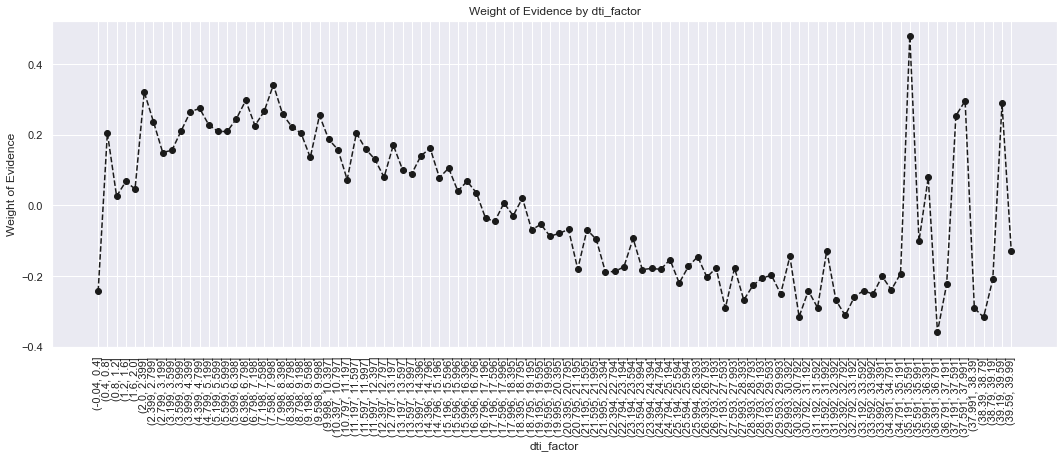

In [106]:
plot_by_woe(df_temp, 90)

In [107]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['dti'] <= 35, : ]

In [108]:
df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)
df_temp = woe_cont(df_input_prep_temp, 'dti_factor', df_target_prep[df_input_prep_temp.index])
df_temp

<ipython-input-108-d89e3acf0a04>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)


,dti_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.035, 0.7]",1270,0.884252,0.003660,1123.0,147.0,0.003632,0.003890,-0.068767,0.02746
1,"(0.7, 1.4]",1558,0.888960,0.004490,1385.0,173.0,0.004479,0.004578,-0.021930,0.02746
2,"(1.4, 2.1]",1856,0.909483,0.005348,1688.0,168.0,0.005459,0.004446,0.205242,0.02746
3,"(2.1, 2.8]",2399,0.911630,0.006913,2187.0,212.0,0.007072,0.005610,0.231606,0.02746
4,"(2.8, 3.5]",2941,0.906154,0.008475,2665.0,276.0,0.008618,0.007304,0.165465,0.02746
...,...,...,...,...,...,...,...,...,...,...
45,"(31.5, 32.2]",2764,0.872648,0.007965,2412.0,352.0,0.007800,0.009315,-0.177513,0.02746
46,"(32.2, 32.9]",2447,0.855742,0.007052,2094.0,353.0,0.006772,0.009342,-0.321730,0.02746
47,"(32.9, 33.6]",2296,0.864547,0.006616,1985.0,311.0,0.006419,0.008230,-0.248512,0.02746
48,"(33.6, 34.3]",2198,0.867607,0.006334,1907.0,291.0,0.006167,0.007701,-0.222130,0.02746


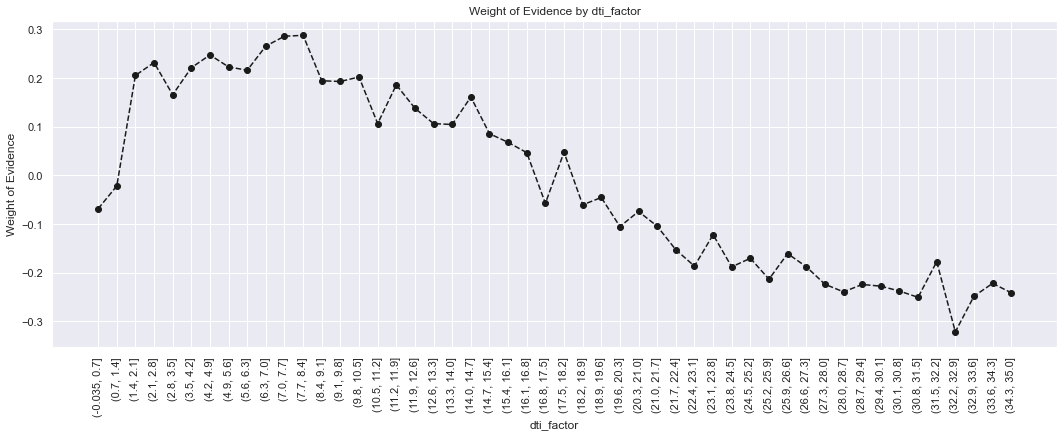

In [109]:
plot_by_woe(df_temp, 90)

In [110]:
df_input_prep['dti:<=1.4'] = np.where((df_input_prep['dti'] <= 1.4), 1, 0)
df_input_prep['dti:1.4-3.5'] = np.where((df_input_prep['dti'] > 1.4) & (df_input_prep['dti'] <= 3.5), 1, 0)
df_input_prep['dti:3.5-7.7'] = np.where((df_input_prep['dti'] > 3.5) & (df_input_prep['dti'] <= 7.7), 1, 0)
df_input_prep['dti:7.7-10.5'] = np.where((df_input_prep['dti'] > 7.7) & (df_input_prep['dti'] <= 10.5), 1, 0)
df_input_prep['dti:10.5-16.1'] = np.where((df_input_prep['dti'] > 10.5) & (df_input_prep['dti'] <= 16.1), 1, 0)
df_input_prep['dti:16.1-20.3'] = np.where((df_input_prep['dti'] > 16.1) & (df_input_prep['dti'] <= 20.3), 1, 0)
df_input_prep['dti:20.3-21.7'] = np.where((df_input_prep['dti'] > 20.3) & (df_input_prep['dti'] <= 21.7), 1, 0)
df_input_prep['dti:21.7-22.4'] = np.where((df_input_prep['dti'] > 21.7) & (df_input_prep['dti'] <= 22.4), 1, 0)
df_input_prep['dti:22.4-35'] = np.where((df_input_prep['dti'] > 22.4) & (df_input_prep['dti'] <= 35), 1, 0)
df_input_prep['dti:>35'] = np.where((df_input_prep['dti'] > 35), 1, 0)

In [111]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_record'])]
df_input_prep_temp['mths_since_last_record_factor'] = pd.cut(df_input_prep_temp['mths_since_last_record'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_record_factor', df_target_prep[df_input_prep_temp.index])
df_temp

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,mths_since_last_record_factor,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,"(-0.129, 2.58]",303831,0.890107,0.868801,270442.0,33389.0,0.867856,0.876536,-0.009952,inf
1,"(2.58, 5.16]",122,0.909836,0.000349,111.0,11.0,0.000356,0.000289,0.209852,inf
2,"(5.16, 7.74]",128,0.914062,0.000366,117.0,11.0,0.000375,0.000289,0.262495,inf
3,"(7.74, 10.32]",229,0.925764,0.000655,212.0,17.0,0.000680,0.000446,0.421590,inf
4,"(10.32, 12.9]",173,0.913295,0.000495,158.0,15.0,0.000507,0.000394,0.252761,inf
...,...,...,...,...,...,...,...,...,...,...
45,"(116.1, 118.68]",1185,0.901266,0.003388,1068.0,117.0,0.003427,0.003072,0.109586,inf
46,"(118.68, 121.26]",344,0.845930,0.000984,291.0,53.0,0.000934,0.001391,-0.398752,inf
47,"(121.26, 123.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf
48,"(123.84, 126.42]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,inf


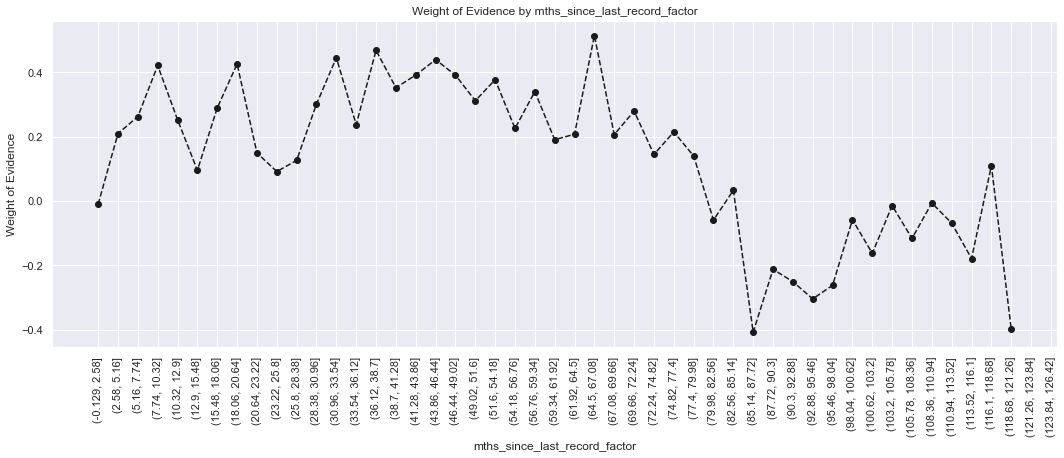

In [112]:
plot_by_woe(df_temp, 90)

In [113]:
df_input_prep['mths_since_last_record:Missing'] = np.where((df_input_prep['mths_since_last_record'].isnull()), 1, 0)
df_input_prep['mths_since_last_record:0-2'] = np.where((df_input_prep['mths_since_last_record'] >= 0) & (df_input_prep['mths_since_last_record'] <= 2), 1, 0)
df_input_prep['mths_since_last_record:3-20'] = np.where((df_input_prep['mths_since_last_record'] >= 3) & (df_input_prep['mths_since_last_record'] <= 20), 1, 0)
df_input_prep['mths_since_last_record:21-31'] = np.where((df_input_prep['mths_since_last_record'] >= 21) & (df_input_prep['mths_since_last_record'] <= 31), 1, 0)
df_input_prep['mths_since_last_record:32-80'] = np.where((df_input_prep['mths_since_last_record'] >= 32) & (df_input_prep['mths_since_last_record'] <= 80), 1, 0)
df_input_prep['mths_since_last_record:81-86'] = np.where((df_input_prep['mths_since_last_record'] >= 81) & (df_input_prep['mths_since_last_record'] <= 86), 1, 0)
df_input_prep['mths_since_last_record:>86'] = np.where((df_input_prep['mths_since_last_record'] > 86), 1, 0)

In [114]:
df_input_prep.columns.values

array(['annual_inc', 'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'inq_fi', 'emp_length_int',
       'earliest_cr_line_in_mnths', 'grade:A', 'grade:B', 'grade:C',
       'grade:D', 'grade:E', 'grade:F', 'grade:G', 'sub_grade:A1',
       'sub_grade:A2', 'sub_grade:A3', 'sub_grade:A4', 'sub_grade:A5',
       'sub_grade:B1', 'sub_grade:B2', 'sub_grade:B3', 'sub_grade:B4',
       'sub_grade:B5', 'sub_grade:C1', 'sub_grade:C2', 'sub_grade:C3',
       'sub_grade:C4', 'sub_grade:C5', 'sub_grade:D1', 'sub_grade:D2',
       'sub_grade:D3', 'sub_grade:D4', 'sub_g

## Part C : Preparing Test Dataset

In [115]:
df_input_train = df_input_prep.copy()

In [116]:
df_input_prep = df_input_test.copy()
df_target_prep = df_target_test.copy()

### Weight of  Evidence for the Categorical Variables

In [117]:
df_temp = woe(df_input_train,'home_ownership',df_target_train)
df_temp

,home_ownership,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
0,OTHER,134,0.783582,0.000383,105.0,29.0,0.000337,0.000761,-0.815119,0.022239
1,NONE,37,0.864865,0.000106,32.0,5.0,0.000103,0.000131,-0.245485,0.022239
2,RENT,141082,0.874009,0.403422,123307.0,17775.0,0.395695,0.466633,-0.164899,0.022239
3,OWN,31326,0.892900,0.089576,27971.0,3355.0,0.089760,0.088076,0.018933,0.022239
4,MORTGAGE,177134,0.904434,0.506512,160206.0,16928.0,0.514105,0.444398,0.145708,0.022239


In [118]:
df_input_prep['home_ownership:RENT_OTHER_NONE_ANY']=sum([df_input_prep['home_ownership:RENT'],
                                                          df_input_prep['home_ownership:OTHER'],
                                                          df_input_prep['home_ownership:NONE'],
                                                          df_input_prep['home_ownership:ANY']]
                                                         )

In [119]:
df_input_prep['addr_state'].unique()

array(['CA', 'NY', 'GA', 'VA', 'FL', 'NC', 'NV', 'IL', 'SC', 'NJ', 'AL',
       'MA', 'LA', 'CO', 'TX', 'PA', 'OR', 'WI', 'CT', 'MN', 'MI', 'WY',
       'AZ', 'WA', 'NH', 'OK', 'WV', 'MO', 'IN', 'UT', 'HI', 'MD', 'KY',
       'NM', 'AR', 'KS', 'OH', 'MT', 'VT', 'TN', 'MS', 'ID', 'SD', 'RI',
       'AK', 'DE', 'DC', 'IA', 'NE'], dtype=object)

In [120]:
df_temp = woe(df_input_prep,'addr_state',df_target_prep)

In [121]:
if ['addr_state:ND'] in df_input_prep.columns.values:
    pass
else:
    df_input_prep['addr_state:ND'] = 0

In [122]:
#first lets seperate state with high value into its own categories
df_temp.sort_values(by ='count', ascending=False)

#CA, NY, TX and FL is high in count so it should be seperate into its own categories

,addr_state,count,proportion_of_good,proportion_of_count,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV
14,CA,17679,0.885231,0.151657,15650.0,2029.0,0.150922,0.157580,-0.043171,inf
9,NY,10175,0.881376,0.087285,8968.0,1207.0,0.086484,0.093740,-0.080574,inf
34,TX,9126,0.903572,0.078286,8246.0,880.0,0.079521,0.068344,0.151463,inf
5,FL,7924,0.874432,0.067975,6929.0,995.0,0.066820,0.077276,-0.145370,inf
39,IL,4619,0.909504,0.039624,4201.0,418.0,0.040513,0.032463,0.221498,inf
...,...,...,...,...,...,...,...,...,...,...
32,SD,237,0.898734,0.002033,213.0,24.0,0.002054,0.001864,0.097140,inf
45,VT,203,0.926108,0.001741,188.0,15.0,0.001813,0.001165,0.442293,inf
1,IA,5,0.800000,0.000043,4.0,1.0,0.000039,0.000078,-0.699804,inf
48,ID,3,1.000000,0.000026,3.0,0.0,0.000029,0.000000,inf,inf


In [123]:
df_input_prep['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_input_prep['addr_state:ND'], df_input_prep['addr_state:NE'],
                                                         df_input_prep['addr_state:IA'], df_input_prep['addr_state:NV'],
                                                         df_input_prep['addr_state:FL'], df_input_prep['addr_state:HI'],
                                                         df_input_prep['addr_state:AL']])

df_input_prep['addr_state:NM_VA'] = sum([df_input_prep['addr_state:NM'], df_input_prep['addr_state:VA']])

df_input_prep['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_input_prep['addr_state:OK'], df_input_prep['addr_state:TN'],
                                              df_input_prep['addr_state:MO'], df_input_prep['addr_state:LA'],
                                              df_input_prep['addr_state:MD'], df_input_prep['addr_state:NC']])

df_input_prep['addr_state:UT_KY_AZ_NJ'] = sum([df_input_prep['addr_state:UT'], df_input_prep['addr_state:KY'],
                                              df_input_prep['addr_state:AZ'], df_input_prep['addr_state:NJ']])

df_input_prep['addr_state:AR_MI_PA_OH_MN'] = sum([df_input_prep['addr_state:AR'], df_input_prep['addr_state:MI'],
                                              df_input_prep['addr_state:PA'], df_input_prep['addr_state:OH'],
                                              df_input_prep['addr_state:MN']])

df_input_prep['addr_state:RI_MA_DE_SD_IN'] = sum([df_input_prep['addr_state:RI'], df_input_prep['addr_state:MA'],
                                              df_input_prep['addr_state:DE'], df_input_prep['addr_state:SD'],
                                              df_input_prep['addr_state:IN']])

df_input_prep['addr_state:GA_WA_OR'] = sum([df_input_prep['addr_state:GA'], df_input_prep['addr_state:WA'],
                                              df_input_prep['addr_state:OR']])

df_input_prep['addr_state:WI_MT'] = sum([df_input_prep['addr_state:WI'], df_input_prep['addr_state:MT']])

df_input_prep['addr_state:IL_CT'] = sum([df_input_prep['addr_state:IL'], df_input_prep['addr_state:CT']])

df_input_prep['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_input_prep['addr_state:KS'], df_input_prep['addr_state:SC'],
                                              df_input_prep['addr_state:CO'], df_input_prep['addr_state:VT'],
                                              df_input_prep['addr_state:AK'], df_input_prep['addr_state:MS']])

df_input_prep['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_input_prep['addr_state:WV'], df_input_prep['addr_state:NH'],
                                              df_input_prep['addr_state:WY'], df_input_prep['addr_state:DC'],
                                              df_input_prep['addr_state:ME'], df_input_prep['addr_state:ID']])

In [124]:
df_temp = woe(df_input_prep, 'verification_status', df_target_prep)

In [125]:
df_temp = woe(df_input_prep, 'purpose', df_target_prep)

In [126]:
df_input_prep['purpose:sm_b_educ'] = sum([ df_input_prep['purpose:small_business'],df_input_prep['purpose:educational']])
df_input_prep['purpose:ren_en_mov_house_other'] = sum([df_input_prep['purpose:renewable_energy'],df_input_prep['purpose:moving'], df_input_prep['purpose:house'],df_input_prep['purpose:other']])
df_input_prep['purpose:med_wed_vac'] = sum([df_input_prep['purpose:medical'],df_input_prep['purpose:wedding'],df_input_prep['purpose:vacation']])
df_input_prep['purpose:major_purch__car__home_impr'] = sum([df_input_prep['purpose:major_purchase'], df_input_prep['purpose:car'],df_input_prep['purpose:home_improvement']])

### Weight of Evidence for Continuous Variable

In [127]:
df_temp = woe_cont(df_input_prep, 'emp_length_int', df_target_prep)

In [128]:
df_input_prep['emp_length_int:0'] = np.where(df_input_prep['emp_length_int'].isin([0]),1,0)
df_input_prep['emp_length_int:1-3'] = np.where(df_input_prep['emp_length_int'].isin(range(1,4)),1,0)
df_input_prep['emp_length_int:4'] = np.where(df_input_prep['emp_length_int'].isin([4]),1,0)
df_input_prep['emp_length_int:5-6'] = np.where(df_input_prep['emp_length_int'].isin(range(5,7)),1,0)
df_input_prep['emp_length_int:7-9'] = np.where(df_input_prep['emp_length_int'].isin(range(7,10)),1,0)
df_input_prep['emp_length_int:10'] = np.where(df_input_prep['emp_length_int'].isin([10]),1,0)        

In [129]:
df_input_prep['earliest_cr_line_in_mnths_factor'] = pd.cut(df_input_prep['earliest_cr_line_in_mnths'], 50)
df_temp = woe_cont(df_input_prep, 'earliest_cr_line_in_mnths_factor', df_target_prep)

In [130]:
df_input_prep['earliest_cr_line_in_mnths:<140'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:141-164'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(140, 165)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:165-247'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(165, 248)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:248-270'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(248, 271)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:271-352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(271, 353)), 1, 0)
df_input_prep['earliest_cr_line_in_mnths:>352'] = np.where(df_input_prep['earliest_cr_line_in_mnths'].isin(range(353, int(df_input_prep['earliest_cr_line_in_mnths'].max()))), 1, 0)

In [131]:
df_temp = woe_cont(df_input_prep, 'delinq_2yrs', df_target_prep)

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [132]:
df_input_prep['delinq_2yrs:0'] = np.where((df_input_prep['delinq_2yrs'] == 0), 1, 0)
df_input_prep['delinq_2yrs:1-6'] = np.where((df_input_prep['delinq_2yrs'] >= 1) & (df_input_prep['delinq_2yrs'] <= 6), 1, 0)
df_input_prep['delinq_2yrs:>6'] = np.where((df_input_prep['delinq_2yrs'] >6), 1, 0)

In [133]:
df_temp = woe_cont(df_input_prep, 'inq_last_6mths', df_target_prep)

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [134]:
df_input_prep['inq_last_6mths:0'] = np.where((df_input_prep['inq_last_6mths'] == 0), 1, 0)
df_input_prep['inq_last_6mths:1-2'] = np.where((df_input_prep['inq_last_6mths'] >= 1) & (df_input_prep['inq_last_6mths'] <= 2), 1, 0)
df_input_prep['inq_last_6mths:3-6'] = np.where((df_input_prep['inq_last_6mths'] >= 3) & (df_input_prep['inq_last_6mths'] <= 6), 1, 0)
df_input_prep['inq_last_6mths:>6'] = np.where((df_input_prep['inq_last_6mths'] > 6), 1, 0)

In [135]:
df_temp = woe_cont(df_input_prep, 'open_acc', df_target_prep)

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [136]:
df_input_prep['open_acc:0'] = np.where((df_input_prep['open_acc'] == 0), 1, 0)
df_input_prep['open_acc:1-3'] = np.where((df_input_prep['open_acc'] >= 1) & (df_input_prep['open_acc'] <= 3), 1, 0)
df_input_prep['open_acc:4-12'] = np.where((df_input_prep['open_acc'] >= 4) & (df_input_prep['open_acc'] <= 12), 1, 0)
df_input_prep['open_acc:13-17'] = np.where((df_input_prep['open_acc'] >= 13) & (df_input_prep['open_acc'] <= 17), 1, 0)
df_input_prep['open_acc:18-22'] = np.where((df_input_prep['open_acc'] >= 18) & (df_input_prep['open_acc'] <= 22), 1, 0)
df_input_prep['open_acc:23-25'] = np.where((df_input_prep['open_acc'] >= 23) & (df_input_prep['open_acc'] <= 25), 1, 0)
df_input_prep['open_acc:26-30'] = np.where((df_input_prep['open_acc'] >= 26) & (df_input_prep['open_acc'] <= 30), 1, 0)
df_input_prep['open_acc:>=31'] = np.where((df_input_prep['open_acc'] >= 31), 1, 0)

In [137]:
df_temp = woe_cont(df_input_prep, 'pub_rec', df_target_prep)

In [138]:
df_input_prep['pub_rec:0-2'] = np.where((df_input_prep['pub_rec'] >= 0) & (df_input_prep['pub_rec'] <= 2), 1, 0)
df_input_prep['pub_rec:3-4'] = np.where((df_input_prep['pub_rec'] >= 3) & (df_input_prep['pub_rec'] <= 4), 1, 0)
df_input_prep['pub_rec:>=5'] = np.where((df_input_prep['pub_rec'] >= 5), 1, 0)

In [139]:
df_temp = woe_cont(df_input_prep, 'acc_now_delinq', df_target_prep)

In [140]:
df_input_prep['acc_now_delinq:0'] = np.where((df_input_prep['acc_now_delinq'] == 0), 1, 0)
df_input_prep['acc_now_delinq:>=1'] = np.where((df_input_prep['acc_now_delinq'] >= 1), 1, 0)

In [141]:
df_input_prep['total_rev_hi_lim_factor'] = pd.cut(df_input_prep['total_rev_hi_lim'], 2000)
df_temp = woe_cont(df_input_prep, 'total_rev_hi_lim_factor', df_target_prep)

C:\Users\azzah\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [142]:
df_input_prep['total_rev_hi_lim:<=5K'] = np.where((df_input_prep['total_rev_hi_lim'] <= 5000), 1, 0)
df_input_prep['total_rev_hi_lim:5K-10K'] = np.where((df_input_prep['total_rev_hi_lim'] > 5000) & (df_input_prep['total_rev_hi_lim'] <= 10000), 1, 0)
df_input_prep['total_rev_hi_lim:10K-20K'] = np.where((df_input_prep['total_rev_hi_lim'] > 10000) & (df_input_prep['total_rev_hi_lim'] <= 20000), 1, 0)
df_input_prep['total_rev_hi_lim:20K-30K'] = np.where((df_input_prep['total_rev_hi_lim'] > 20000) & (df_input_prep['total_rev_hi_lim'] <= 30000), 1, 0)
df_input_prep['total_rev_hi_lim:30K-40K'] = np.where((df_input_prep['total_rev_hi_lim'] > 30000) & (df_input_prep['total_rev_hi_lim'] <= 40000), 1, 0)
df_input_prep['total_rev_hi_lim:40K-55K'] = np.where((df_input_prep['total_rev_hi_lim'] > 40000) & (df_input_prep['total_rev_hi_lim'] <= 55000), 1, 0)
df_input_prep['total_rev_hi_lim:55K-95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 55000) & (df_input_prep['total_rev_hi_lim'] <= 95000), 1, 0)
df_input_prep['total_rev_hi_lim:>95K'] = np.where((df_input_prep['total_rev_hi_lim'] > 95000), 1, 0)

In [143]:
df_input_prep['annual_inc_factor'] = pd.cut(df_input_prep['annual_inc'], 100)
df_temp = woe_cont(df_input_prep, 'annual_inc_factor', df_target_prep)

In [144]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['annual_inc'] <= 150000, : ]

In [145]:
df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)
df_temp = woe_cont(df_input_prep_temp, 'annual_inc_factor', df_target_prep[df_input_prep_temp.index])

<ipython-input-145-a37356ae40ae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['annual_inc_factor'] = pd.cut(df_input_prep_temp['annual_inc'], 50)


In [146]:
df_input_prep['annual_inc:<20K'] = np.where((df_input_prep['annual_inc'] <= 20000), 1, 0)
df_input_prep['annual_inc:20K-30K'] = np.where((df_input_prep['annual_inc'] > 20000) & (df_input_prep['annual_inc'] <= 30000), 1, 0)
df_input_prep['annual_inc:30K-40K'] = np.where((df_input_prep['annual_inc'] > 30000) & (df_input_prep['annual_inc'] <= 40000), 1, 0)
df_input_prep['annual_inc:40K-50K'] = np.where((df_input_prep['annual_inc'] > 40000) & (df_input_prep['annual_inc'] <= 50000), 1, 0)
df_input_prep['annual_inc:50K-60K'] = np.where((df_input_prep['annual_inc'] > 50000) & (df_input_prep['annual_inc'] <= 60000), 1, 0)
df_input_prep['annual_inc:60K-70K'] = np.where((df_input_prep['annual_inc'] > 60000) & (df_input_prep['annual_inc'] <= 70000), 1, 0)
df_input_prep['annual_inc:70K-80K'] = np.where((df_input_prep['annual_inc'] > 70000) & (df_input_prep['annual_inc'] <= 80000), 1, 0)
df_input_prep['annual_inc:80K-90K'] = np.where((df_input_prep['annual_inc'] > 80000) & (df_input_prep['annual_inc'] <= 90000), 1, 0)
df_input_prep['annual_inc:90K-100K'] = np.where((df_input_prep['annual_inc'] > 90000) & (df_input_prep['annual_inc'] <= 100000), 1, 0)
df_input_prep['annual_inc:100K-125K'] = np.where((df_input_prep['annual_inc'] > 100000) & (df_input_prep['annual_inc'] <= 125000), 1, 0)
df_input_prep['annual_inc:125K-150K'] = np.where((df_input_prep['annual_inc'] > 125000) & (df_input_prep['annual_inc'] <= 150000), 1, 0)
df_input_prep['annual_inc:>150K'] = np.where((df_input_prep['annual_inc'] > 150000), 1, 0)

In [147]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_delinq'])]
df_input_prep_temp['mths_since_last_delinq_factor'] = pd.cut(df_input_prep_temp['mths_since_last_delinq'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_delinq_factor', df_target_prep[df_input_prep_temp.index])

In [148]:
df_input_prep['mths_since_last_delinq:Missing'] = np.where((df_input_prep['mths_since_last_delinq'].isnull()), 1, 0)
df_input_prep['mths_since_last_delinq:0-3'] = np.where((df_input_prep['mths_since_last_delinq'] >= 0) & (df_input_prep['mths_since_last_delinq'] <= 3), 1, 0)
df_input_prep['mths_since_last_delinq:4-30'] = np.where((df_input_prep['mths_since_last_delinq'] >= 4) & (df_input_prep['mths_since_last_delinq'] <= 30), 1, 0)
df_input_prep['mths_since_last_delinq:31-56'] = np.where((df_input_prep['mths_since_last_delinq'] >= 31) & (df_input_prep['mths_since_last_delinq'] <= 56), 1, 0)
df_input_prep['mths_since_last_delinq:>=57'] = np.where((df_input_prep['mths_since_last_delinq'] >= 57), 1, 0)

In [149]:
df_input_prep['dti_factor'] = pd.cut(df_input_prep['dti'], 100)
df_temp = woe_cont(df_input_prep, 'dti_factor', df_target_prep)

In [150]:
df_input_prep_temp = df_input_prep.loc[df_input_prep['dti'] <= 35, : ]

In [151]:
df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)
df_temp = woe_cont(df_input_prep_temp, 'dti_factor', df_target_prep[df_input_prep_temp.index])

<ipython-input-151-f6adc51910dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input_prep_temp['dti_factor'] = pd.cut(df_input_prep_temp['dti'], 50)


In [152]:
df_input_prep['dti:<=1.4'] = np.where((df_input_prep['dti'] <= 1.4), 1, 0)
df_input_prep['dti:1.4-3.5'] = np.where((df_input_prep['dti'] > 1.4) & (df_input_prep['dti'] <= 3.5), 1, 0)
df_input_prep['dti:3.5-7.7'] = np.where((df_input_prep['dti'] > 3.5) & (df_input_prep['dti'] <= 7.7), 1, 0)
df_input_prep['dti:7.7-10.5'] = np.where((df_input_prep['dti'] > 7.7) & (df_input_prep['dti'] <= 10.5), 1, 0)
df_input_prep['dti:10.5-16.1'] = np.where((df_input_prep['dti'] > 10.5) & (df_input_prep['dti'] <= 16.1), 1, 0)
df_input_prep['dti:16.1-20.3'] = np.where((df_input_prep['dti'] > 16.1) & (df_input_prep['dti'] <= 20.3), 1, 0)
df_input_prep['dti:20.3-21.7'] = np.where((df_input_prep['dti'] > 20.3) & (df_input_prep['dti'] <= 21.7), 1, 0)
df_input_prep['dti:21.7-22.4'] = np.where((df_input_prep['dti'] > 21.7) & (df_input_prep['dti'] <= 22.4), 1, 0)
df_input_prep['dti:22.4-35'] = np.where((df_input_prep['dti'] > 22.4) & (df_input_prep['dti'] <= 35), 1, 0)
df_input_prep['dti:>35'] = np.where((df_input_prep['dti'] > 35), 1, 0)

In [153]:
df_input_prep_temp = df_input_prep[pd.notnull(df_input_prep['mths_since_last_record'])]
df_input_prep_temp['mths_since_last_record_factor'] = pd.cut(df_input_prep_temp['mths_since_last_record'], 50)
df_temp = woe_cont(df_input_prep_temp, 'mths_since_last_record_factor', df_target_prep[df_input_prep_temp.index])

In [154]:
df_input_prep['mths_since_last_record:Missing'] = np.where((df_input_prep['mths_since_last_record'].isnull()), 1, 0)
df_input_prep['mths_since_last_record:0-2'] = np.where((df_input_prep['mths_since_last_record'] >= 0) & (df_input_prep['mths_since_last_record'] <= 2), 1, 0)
df_input_prep['mths_since_last_record:3-20'] = np.where((df_input_prep['mths_since_last_record'] >= 3) & (df_input_prep['mths_since_last_record'] <= 20), 1, 0)
df_input_prep['mths_since_last_record:21-31'] = np.where((df_input_prep['mths_since_last_record'] >= 21) & (df_input_prep['mths_since_last_record'] <= 31), 1, 0)
df_input_prep['mths_since_last_record:32-80'] = np.where((df_input_prep['mths_since_last_record'] >= 32) & (df_input_prep['mths_since_last_record'] <= 80), 1, 0)
df_input_prep['mths_since_last_record:81-86'] = np.where((df_input_prep['mths_since_last_record'] >= 81) & (df_input_prep['mths_since_last_record'] <= 86), 1, 0)
df_input_prep['mths_since_last_record:>86'] = np.where((df_input_prep['mths_since_last_record'] > 86), 1, 0)

## Prepared Data 

In [155]:
df_input_test = df_input_prep.copy()
df_input_test = df_input_test.select_dtypes(exclude=['category','object'])
df_input_test.drop(columns=['annual_inc', 'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'inq_fi', 'emp_length_int','earliest_cr_line_in_mnths'], inplace = True)
df_input_train = df_input_train.select_dtypes(exclude=['category','object'])
df_input_train.drop(columns=['annual_inc', 'pymnt_plan', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'out_prncp',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'annual_inc_joint', 'acc_now_delinq', 'tot_coll_amt',
       'tot_cur_bal', 'total_rev_hi_lim', 'inq_fi', 'emp_length_int','earliest_cr_line_in_mnths'], inplace = True)

In [156]:
df_input_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349713 entries, 45440 to 91230
Columns: 208 entries, grade:A to mths_since_last_record:>86
dtypes: int32(74), int64(2), uint8(132)
memory usage: 150.7 MB


In [157]:
df_input_test.head()

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G,sub_grade:A1,sub_grade:A2,sub_grade:A3,...,dti:21.7-22.4,dti:22.4-35,dti:>35,mths_since_last_record:Missing,mths_since_last_record:0-2,mths_since_last_record:3-20,mths_since_last_record:21-31,mths_since_last_record:32-80,mths_since_last_record:81-86,mths_since_last_record:>86
100123,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
56778,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
365101,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
200324,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
145449,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [158]:

df_input_train.to_csv('df_input_train.csv')
df_input_test.to_csv('df_input_test.csv')
df_target_train.to_csv('df_target_train.csv')
df_target_test.to_csv('df_target_test.csv')

In [159]:
check = pd.concat([df_input_train, df_target_train], axis=1)
check.to_csv('check.csv')

# PD Model

Now lets predict the model using Logistic Regression

## Logistic Regression

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [161]:
reg = LogisticRegression()

In [162]:
reg.fit(df_input_train, df_target_train)

C:\Users\azzah\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [163]:
feature_name = df_input_train.columns.values

Below are the coefficient for each of the variable

In [164]:
summary_table = pd.DataFrame(columns = ['Feature name'], data = feature_name)
summary_table['Coefficients'] = np.transpose(reg.coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', reg.intercept_[0]]
summary_table = summary_table.sort_index()
summary_table

,Feature name,Coefficients
0,Intercept,0.387313
1,grade:A,1.170386
2,grade:B,0.505177
3,grade:C,0.177458
4,grade:D,-0.075055
...,...,...
204,mths_since_last_record:3-20,0.177804
205,mths_since_last_record:21-31,0.178706
206,mths_since_last_record:32-80,0.354098
207,mths_since_last_record:81-86,-0.057512


# Test the PD Model

In [165]:
from sklearn.metrics import auc, plot_roc_curve, classification_report, confusion_matrix, accuracy_score, make_scorer, roc_curve, roc_auc_score, log_loss, plot_confusion_matrix
predictions_rf = reg.predict(df_input_test)
print(classification_report(df_target_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.44      0.00      0.00     12876
           1       0.89      1.00      0.94    103696

    accuracy                           0.89    116572
   macro avg       0.67      0.50      0.47    116572
weighted avg       0.84      0.89      0.84    116572



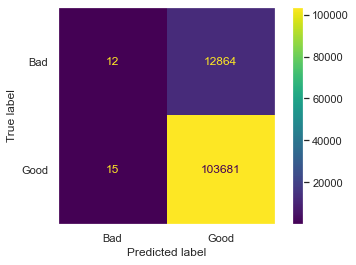

In [166]:
plt.rcParams['axes.grid']=False
plot_confusion_matrix(reg,
                      df_input_test,
                      df_target_test,
                      values_format='d',
                      display_labels=['Bad', 'Good'])

## ROC - AUC

In [167]:
from sklearn.metrics import roc_curve, roc_auc_score

In [176]:
y_hat_test_proba = reg.predict_proba(df_input_test)
y_hat_test_proba = y_hat_test_proba[:][:,1]
df_temp = df_target_test
df_temp.reset_index(drop = True, inplace = True)
df_actual_predicted_probs = pd.concat([df_temp, pd.DataFrame(y_hat_test_proba)], axis = 1)

In [177]:
df_actual_predicted_probs.columns = ['df_target_test', 'y_hat_test_proba']
df_actual_predicted_probs.index = df_target_test.index

In [178]:
roc_curve(df_actual_predicted_probs['df_target_test'], df_actual_predicted_probs['y_hat_test_proba'])

(array([0.        , 0.        , 0.        , ..., 0.99984467, 0.99984467,
        1.        ]),
 array([0.00000000e+00, 9.64357352e-06, 3.08594353e-04, ...,
        9.99990356e-01, 1.00000000e+00, 1.00000000e+00]),
 array([1.99480409, 0.99480409, 0.99202098, ..., 0.41564813, 0.40873748,
        0.19720962]))

In [179]:
fpr, tpr, thresholds = roc_curve(df_actual_predicted_probs['df_target_test'],
                                 df_actual_predicted_probs['y_hat_test_proba'])

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0.5, 1.0, 'ROC curve')

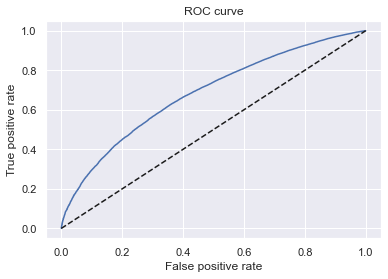

In [181]:
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle = '--', color = 'k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [182]:
AUROC = roc_auc_score(df_actual_predicted_probs['df_target_test'], df_actual_predicted_probs['y_hat_test_proba'])
AUROC

0.6833815747182039

The ROC_AUC score is pretty good but not good enough. we can see from the confussion matrix that this model ability to pradict 'Bad' Borrower or defaulted borrower is not to good. To make this model perform better, we need to do more selection to the variables, we can also change the thershold of the Logistic Regression. We cannot change the model that is made because Logistic Regression model is the best model to create score card that is used nation wide right now.